# Notebook Dedicated to Build a Handcraft DNN Model Architectura that learns from cos($\alpha$) and $t_{res}$ 1D Distributions.

The idea is to pass each bin count on cos(α) and Time residual, energy and position as features to train the model.

In [1]:
#import uproot
import numpy as np

import pickle
 
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import font_manager

import seaborn as sn
import pandas as pd

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, concatenate, Dropout
from keras.losses import BinaryCrossentropy
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve, auc
from sklearn.utils import shuffle
import optuna
from keras.backend import clear_session

# Useful Functions

## Multi-color Generator

In [2]:
import colorsys
# Función para generar variantes más claras y más oscuras de un color
def generate_color_variants(base_color, num_variants, factor = 0.3):
    # Convertir el color base a valores de HSV
    r, g, b = base_color
    h, l, s = colorsys.rgb_to_hls(r, g, b)
    
    # Generar variantes
    variants = []
    for i in range(1, num_variants + 1):
        # Hacer el color más claro
        lighter = colorsys.hls_to_rgb(h, min(1, l * (1 + factor * i)), s)
        # Hacer el color más oscuro
        darker = colorsys.hls_to_rgb(h, max(0, l * (1 - factor * i)), s)
        variants.append(lighter)
        variants.append(darker)
        
    return variants

# Color base (rojo)
base_red = (1, 0, 0) # RGB para rojo puro
# Color base (azuk)
base_blue = (0, 0, 1) # RGB para azul puro
num_variants = 5

red_variants = generate_color_variants(base_red, num_variants)
blue_variants = generate_color_variants(base_blue, num_variants)

# Load Data

## Define the Data Cuts of the original pd.DataFrame

In [3]:
energy_inf_cut = 2.5
energy_sup_cut = 12

posr_cut = 5500

time_res_inf_cut = -1
time_res_sup_cut = 5

nhits_cut = 20

n_bins_cos = 12
n_bins_time = 12

In [4]:
#Directories
train_dataset_dir = "E:/Data/solars/mc/ML Data/pd_dataframe/1D Histograms/Train/"
train_dataset_fname = f'df_cos_{n_bins_cos}_time_{n_bins_time}_bins_E_{energy_inf_cut}_{energy_sup_cut}_MeV_R_{posr_cut}_mm_Delta_{time_res_inf_cut}_{time_res_sup_cut}_ns.csv'

test_dataset_dir = "E:/Data/solars/mc/ML Data/pd_dataframe/1D Histograms/Test/"
test_dataset_fname = f'df_cos_{n_bins_cos}_time_{n_bins_time}_bins_E_{energy_inf_cut}_{energy_sup_cut}_MeV_R_{posr_cut}_mm_Delta_{time_res_inf_cut}_{time_res_sup_cut}_ns.csv'

#Load in Pandas  DataFrame
df_train = shuffle(pd.read_csv(train_dataset_dir + train_dataset_fname))
df_test = shuffle(pd.read_csv(test_dataset_dir + test_dataset_fname))

In [5]:
df_train.describe()

,cos_0,cos_1,cos_2,cos_3,cos_4,cos_5,cos_6,cos_7,cos_8,cos_9,...,chi_sqrt_bkg,jsd_sig,jsd_bkg,emd_sig,emd_bkg,energy (MeV),radius (mm),nhits,IsNu,IsTl
count,1.502813e+06,1.502813e+06,1.502813e+06,1.502813e+06,1.502813e+06,1.502813e+06,1.502813e+06,1.502813e+06,1.502813e+06,1.502813e+06,...,1.502813e+06,1.502813e+06,1.502813e+06,1.502813e+06,1.502813e+06,1.502813e+06,1.502813e+06,1.502813e+06,1.502813e+06,1.502813e+06
mean,1.072412e+01,1.069690e+01,1.052237e+01,1.035581e+01,1.037639e+01,1.028084e+01,1.035724e+01,1.042671e+01,1.052552e+01,1.062043e+01,...,8.041031e-01,1.006036e-01,1.001235e-01,3.550559e-01,3.528048e-01,4.661723e+00,4.096745e+03,1.257121e+02,6.572734e-01,3.427266e-01
std,1.787176e+01,1.297819e+01,1.055255e+01,9.182380e+00,8.441184e+00,8.057143e+00,8.054549e+00,8.357241e+00,9.163633e+00,1.071582e+01,...,7.150114e-01,6.176662e-02,6.423550e-02,1.834905e-01,1.860564e-01,1.753361e+00,1.072686e+03,5.465191e+01,4.746211e-01,4.746211e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,1.837582e-02,1.899016e-03,2.243835e-03,1.111793e-02,1.282913e-02,2.500002e+00,3.176235e+01,2.000000e+01,0.000000e+00,0.000000e+00
25%,1.000000e+00,2.000000e+00,3.000000e+00,4.000000e+00,4.000000e+00,5.000000e+00,5.000000e+00,4.000000e+00,4.000000e+00,3.000000e+00,...,3.414201e-01,5.377856e-02,5.076882e-02,1.985818e-01,1.926671e-01,3.457328e+00,3.424745e+03,8.600000e+01,0.000000e+00,0.000000e+00
50%,4.000000e+00,5.000000e+00,7.000000e+00,8.000000e+00,8.000000e+00,8.000000e+00,8.000000e+00,8.000000e+00,8.000000e+00,7.000000e+00,...,5.511694e-01,8.468341e-02,8.248405e-02,3.254062e-01,3.246557e-01,4.015488e+00,4.333659e+03,1.160000e+02,1.000000e+00,0.000000e+00
75%,1.200000e+01,1.500000e+01,1.500000e+01,1.500000e+01,1.400000e+01,1.400000e+01,1.400000e+01,1.400000e+01,1.500000e+01,1.500000e+01,...,1.001110e+00,1.355080e-01,1.369698e-01,4.996635e-01,4.996529e-01,5.501708e+00,4.976263e+03,1.530000e+02,1.000000e+00,1.000000e+00
max,2.240000e+02,1.110000e+02,9.100000e+01,8.200000e+01,7.900000e+01,7.400000e+01,7.500000e+01,7.800000e+01,8.100000e+01,9.300000e+01,...,8.296711e+00,4.355173e-01,4.399689e-01,8.672494e-01,8.661090e-01,1.199876e+01,5.500000e+03,4.300000e+02,1.000000e+00,1.000000e+00


# Data Procesing

## Define and Apply Energy and Position Cuts

In [6]:
energy_cut = 5
radial_cut = 4500

condition_train = (df_train['energy (MeV)'] <= energy_cut) & (df_train['radius (mm)'] <= radial_cut)
condition_test = (df_test['energy (MeV)'] <= energy_cut) & (df_test['radius (mm)'] <= radial_cut)

df_train = df_train[condition_train]
df_test = df_test[condition_test]

### Extract Train Data

In [7]:
# ======== Separate signal from background ========
df_train_sig = df_train[df_train['IsNu'] == 1]
df_train_bkg = df_train[df_train['IsTl'] == 1]

#======== Igualar cantidad de datos de neutrinos solares y de Tálio ========
N_solar_ev = df_train_sig.shape[0]
N_Tl_ev = df_train_bkg.shape[0]

if N_solar_ev > N_Tl_ev:
    df_train_sig = (df_train_sig.iloc[:N_Tl_ev, :])

else:
    df_train_bkg = (df_train_bkg.iloc[:N_solar_ev, :])


# ======== Re-join the Signal and Background Data and Separate labels ========

df_train_join = shuffle(pd.concat([df_train_sig, df_train_bkg], axis=0, ignore_index = True))
# ------ Extract Lables ------
labels_train = df_train_join[['IsNu', 'IsTl']]
# ------ Remove lables from dataset ------
df_train_join = df_train_join.drop(columns = ['IsNu', 'IsTl'])
df_train_join

,cos_0,cos_1,cos_2,cos_3,cos_4,cos_5,cos_6,cos_7,cos_8,cos_9,...,time_entropy,chi_sqrt_sig,chi_sqrt_bkg,jsd_sig,jsd_bkg,emd_sig,emd_bkg,energy (MeV),radius (mm),nhits
483835,1,1,4,4,6,6,6,4,4,6,...,2.162616,0.208491,0.193022,0.033444,0.031666,0.112451,0.119741,3.570986,2663.864746,48
372381,9,13,15,3,3,7,5,4,2,0,...,1.944453,0.650613,0.612308,0.085155,0.079533,0.350258,0.332601,3.588921,2705.217529,66
124732,19,11,11,8,4,5,6,4,3,1,...,2.093265,0.758606,0.767776,0.114551,0.109327,0.467051,0.449394,4.136052,2814.742432,72
250718,14,12,14,17,25,17,12,11,5,5,...,2.148600,0.344278,0.284949,0.049261,0.041774,0.234742,0.217085,4.730788,4420.260254,137
473893,9,11,7,10,7,3,4,8,3,1,...,2.093571,0.339306,0.316800,0.051325,0.047433,0.276283,0.258626,3.544065,3187.481689,68
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
552769,1,4,5,5,3,3,4,4,10,5,...,1.863424,0.228561,0.259911,0.028758,0.030880,0.155965,0.173622,3.542243,2018.285156,56
90149,9,14,13,11,9,13,6,4,8,0,...,2.173163,0.430789,0.386787,0.089629,0.082198,0.315444,0.297787,3.798973,3794.243896,89
492105,27,18,8,12,3,2,2,2,0,1,...,2.185363,1.678974,1.724166,0.199757,0.196543,0.636218,0.618561,3.295119,3835.873047,75
405652,24,20,19,15,3,2,6,1,0,1,...,2.172851,1.262182,1.256972,0.180233,0.175726,0.579672,0.562015,4.206294,3257.183105,92


### Extract Test Data

In [8]:
# ======== Separate signal from background ========
df_test_sig = df_test[df_test['IsNu'] == 1]
df_test_bkg = df_test[df_test['IsTl'] == 1]

#======== Igualar cantidad de datos de neutrinos solares y de Tálio ========
N_solar_ev = df_test_sig.shape[0]
N_Tl_ev = df_test_bkg.shape[0]

if N_solar_ev > N_Tl_ev:
    df_test_sig = (df_test_sig.iloc[:N_Tl_ev, :])

else:
    df_test_bkg = (df_test_bkg.iloc[:N_solar_ev, :])


# ======== Re-join the Background and Background Data and Separate labels ========

df_test_join = shuffle(pd.concat([df_test_sig, df_test_bkg], axis=0, ignore_index = True))
# ------ Extract Lables ------
labels_test = df_test_join[['IsNu', 'IsTl']]
# ------ Remove lables from dataset ------
df_test_join = df_test_join.drop(columns = ['IsNu', 'IsTl'])
df_test_join

,cos_0,cos_1,cos_2,cos_3,cos_4,cos_5,cos_6,cos_7,cos_8,cos_9,...,time_entropy,chi_sqrt_sig,chi_sqrt_bkg,jsd_sig,jsd_bkg,emd_sig,emd_bkg,energy (MeV),radius (mm),nhits
21930,8,10,10,7,4,10,7,2,2,2,...,2.181915,0.517057,0.445320,0.087173,0.076258,0.351409,0.322099,4.558779,1978.119751,63
14230,3,6,9,7,7,4,5,9,2,7,...,2.097337,0.200437,0.188081,0.027863,0.025716,0.112097,0.085423,2.657202,3643.191406,65
17362,20,11,5,7,7,4,3,2,3,2,...,2.013957,0.844891,0.787244,0.081910,0.075350,0.443054,0.413744,4.078661,2363.851807,67
1298,2,4,4,8,14,15,7,13,9,7,...,2.122228,0.228745,0.211766,0.031157,0.030881,0.109754,0.130460,3.647602,4277.494629,101
23071,1,1,3,2,1,3,5,6,11,13,...,2.128643,0.703888,0.820224,0.089978,0.102370,0.442983,0.472292,3.859444,2960.023438,75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6890,0,2,2,1,2,3,0,3,5,10,...,2.191478,0.894533,1.020039,0.119833,0.132142,0.446872,0.476181,3.253487,2472.674561,48
30054,32,19,13,6,7,6,0,2,1,0,...,2.055849,1.718269,1.631323,0.214351,0.203773,0.650997,0.621687,3.447864,3789.994873,86
5615,0,0,0,1,3,3,5,5,13,8,...,2.071992,1.305904,1.439226,0.167591,0.180187,0.573880,0.603189,4.618978,2941.553223,83
30076,1,6,10,14,13,11,7,5,5,6,...,2.048948,0.433552,0.372883,0.063300,0.056970,0.216360,0.192510,2.965268,4197.802734,81


## Data Transformation

### Standards Scaler()

In [54]:
# Train Transform History
scaler_cos_train = StandardScaler()
scaler_time_train = StandardScaler()
scaler_energy_train = StandardScaler()
scaler_position_train = StandardScaler()

# Test Transform History
scaler_cos_test = StandardScaler()
scaler_time_test = StandardScaler()
scaler_energy_test = StandardScaler()
scaler_position_test = StandardScaler()

### MinMaxScaler()

In [59]:
#Intervals for MinMax Scaler ------------------------------------
epsilon = 1e-2
min_val = 0 + epsilon
max_val = 1 + epsilon # equals to one + epsilon
# ---------------------------------------------------------------

scaler_energy_train = MinMaxScaler(feature_range=(min_val, max_val))
scaler_position_train = MinMaxScaler(feature_range=(min_val, max_val))

scaler_energy_test = MinMaxScaler(feature_range=(min_val, max_val))
scaler_position_test = MinMaxScaler(feature_range=(min_val, max_val))

### Pipeline MinMaxScaler(StandardScaler()) Avoid Reruning Again!

In [9]:
#Intervals for MinMax Scaler ------------------------------------
epsilon = 1e-2
min_val = 0 + epsilon
max_val = 1 + epsilon # equals to one + epsilon

# ======== Train Transformation ========

# Transform from radial position to norm. vol:
df_train_join['norm_vol'] =  (df_train_join['radius (mm)']/posr_cut) ** 3
df_train_join = df_train_join.drop(columns = ['radius (mm)'])

scaling_pipeline_train = Pipeline([('std', StandardScaler()),
    ('minmax', MinMaxScaler(feature_range=(min_val, max_val)))])

df_train_scaled = pd.DataFrame(scaling_pipeline_train.fit_transform(df_train_join),columns = df_train_join.columns)

# ======== Test Transformation ========

# Transform from radial position to norm. vol:
df_test_join['norm_vol'] =  (df_test_join['radius (mm)']/posr_cut) ** 3
df_test_join = df_test_join.drop(columns = ['radius (mm)'])

scaling_pipeline_test = Pipeline([('std', StandardScaler()),
    ('minmax', MinMaxScaler(feature_range=(min_val, max_val)))])

df_test_scaled = pd.DataFrame(scaling_pipeline_test.fit_transform(df_test_join),columns = df_test_join.columns)

array([[0.22111111, 0.22153846, 0.23      , ..., 0.66442161, 0.33911392,
        0.25472528],
       [0.16555556, 0.24076923, 0.29      , ..., 0.9023169 , 0.75050633,
        0.95778025],
       [0.08777778, 0.10615385, 0.07      , ..., 0.33070354, 0.18088608,
        0.14218863],
       ...,
       [0.07666667, 0.20230769, 0.05      , ..., 0.6963757 , 0.45303797,
        0.61665323],
       [0.06555556, 0.10615385, 0.15      , ..., 0.73068957, 0.45303797,
        0.55461567],
       [0.11      , 0.27923077, 0.27      , ..., 0.52958991, 0.44670886,
        0.60943156]])

# Plots of Transf. Data Verification

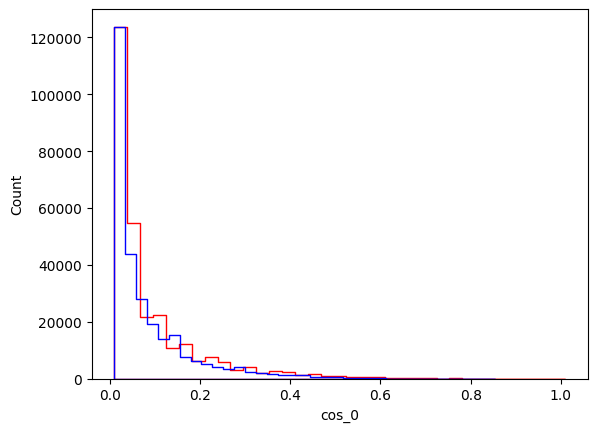

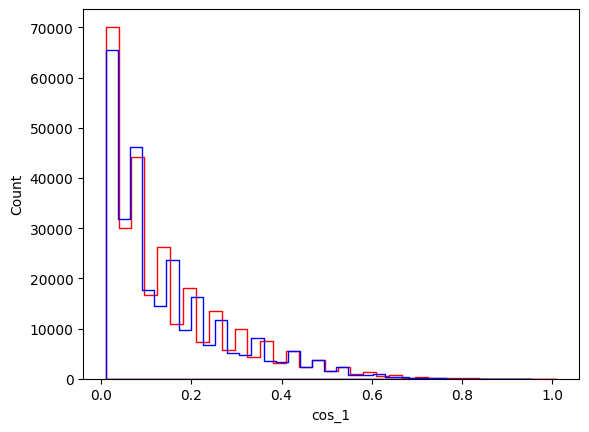

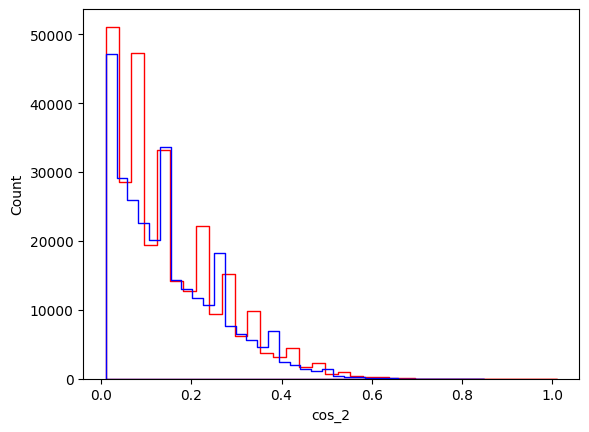

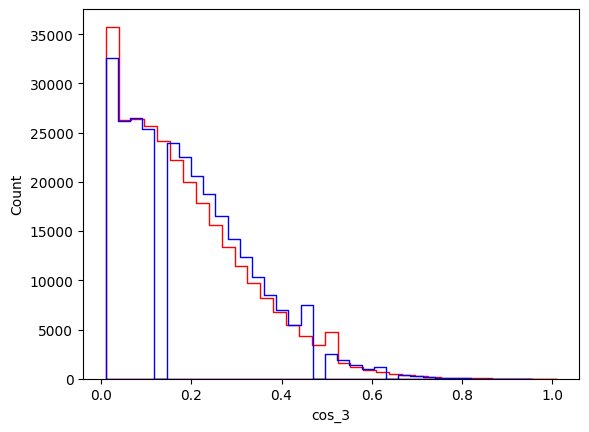

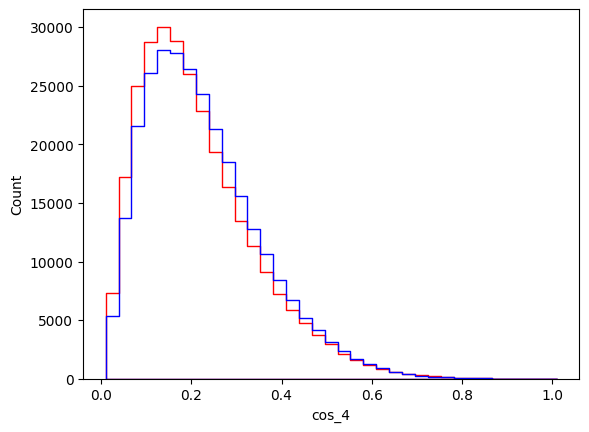

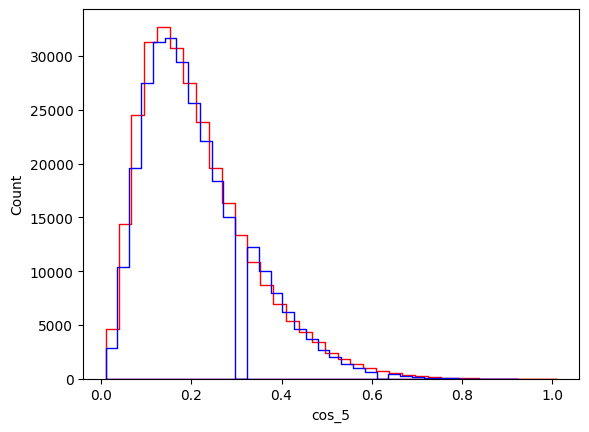

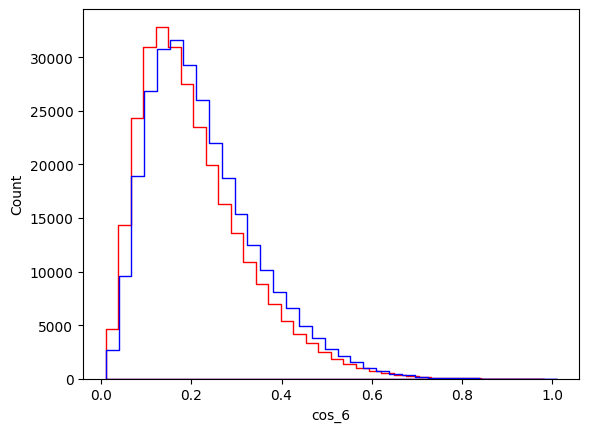

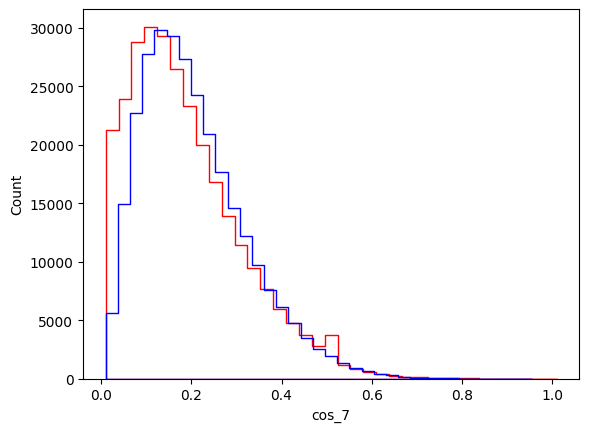

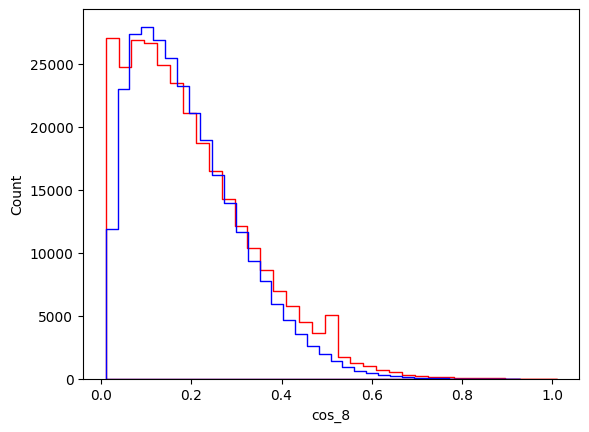

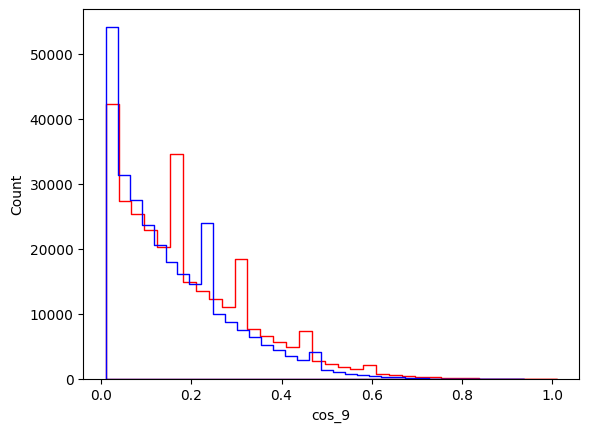

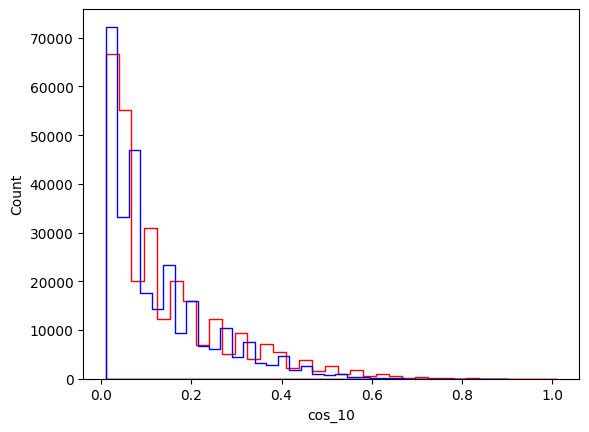

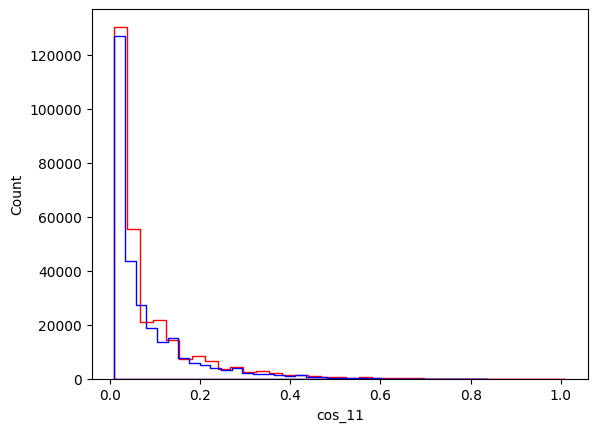

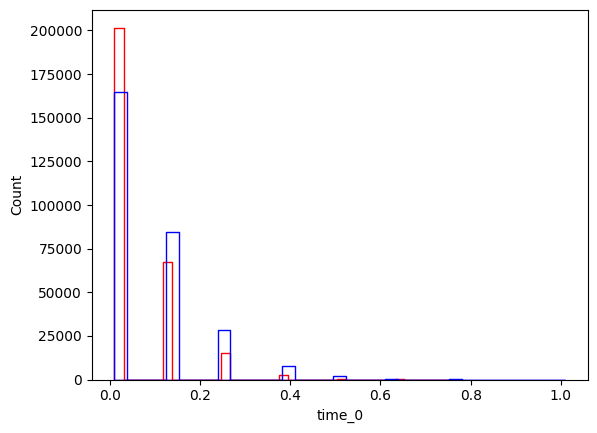

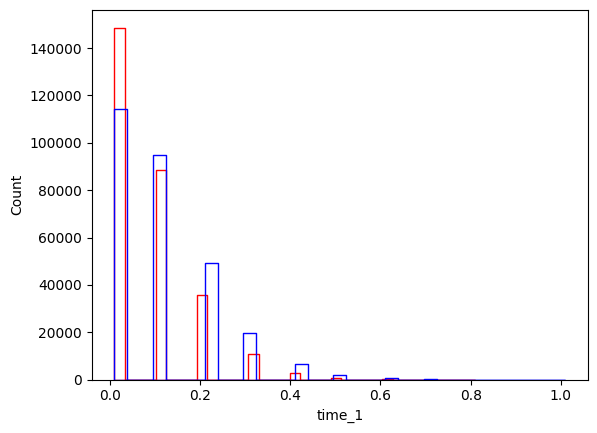

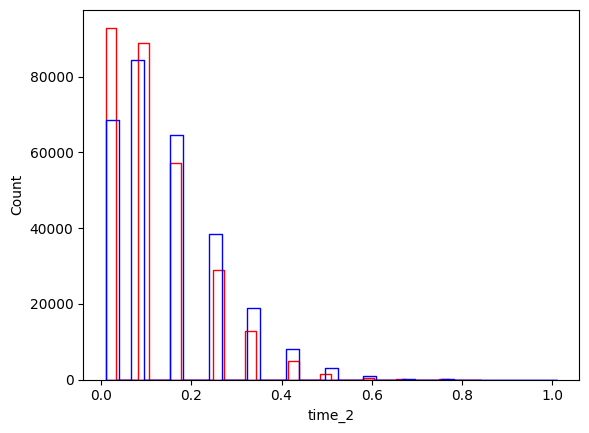

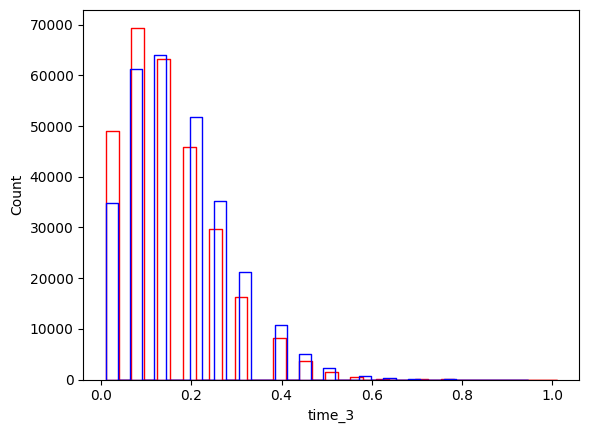

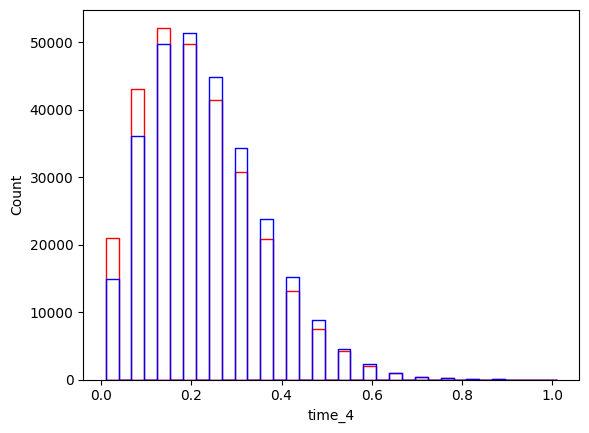

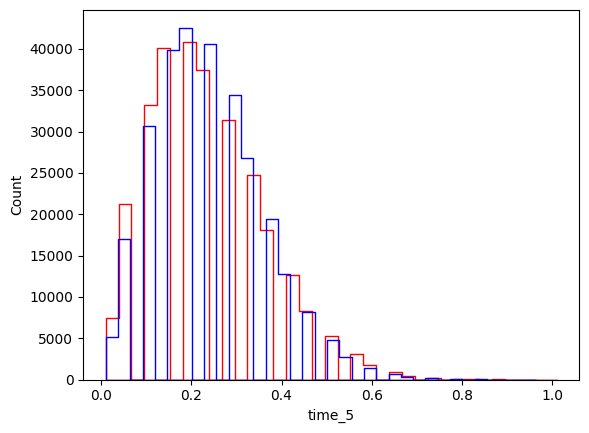

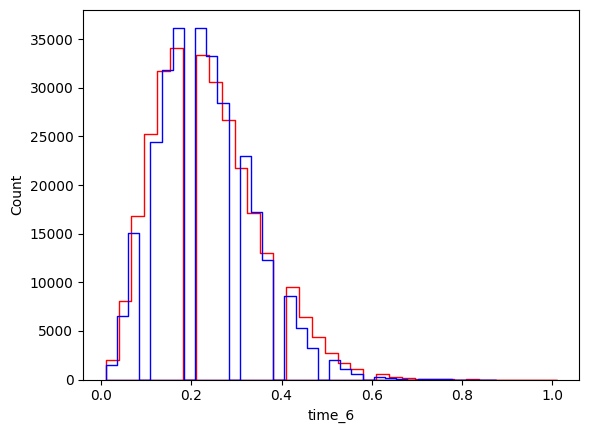

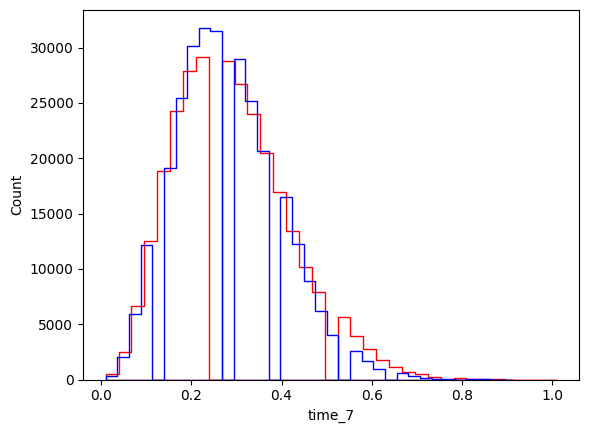

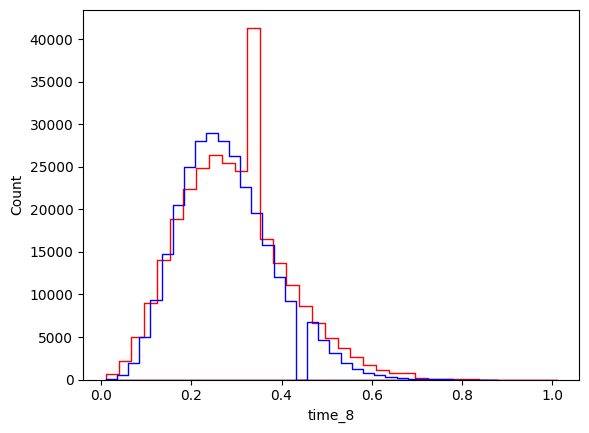

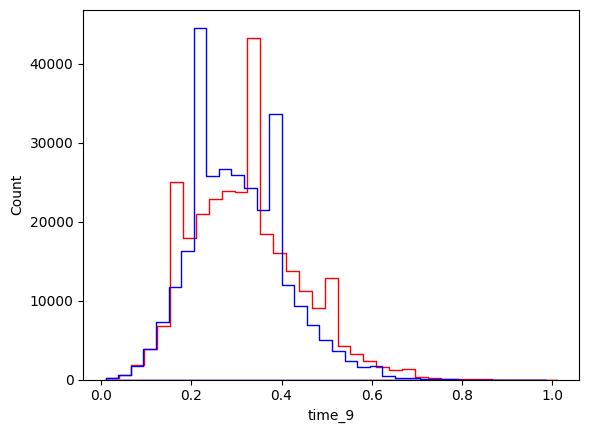

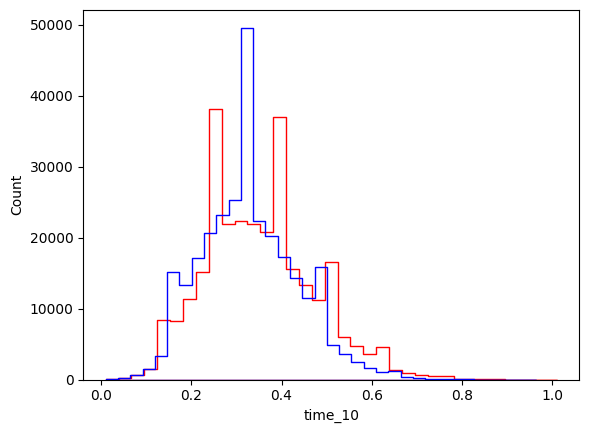

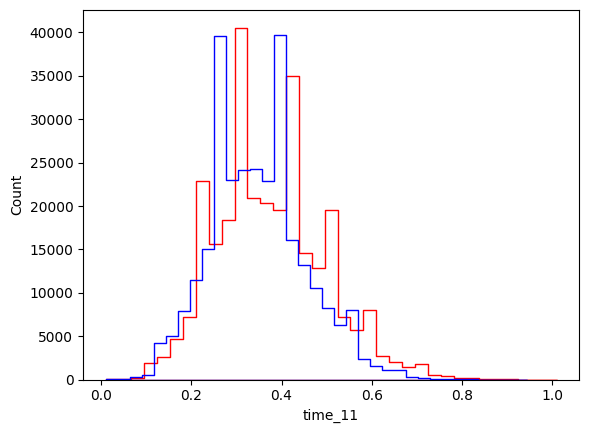

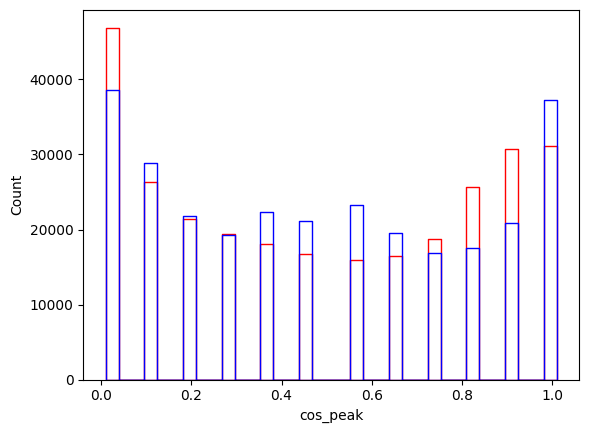

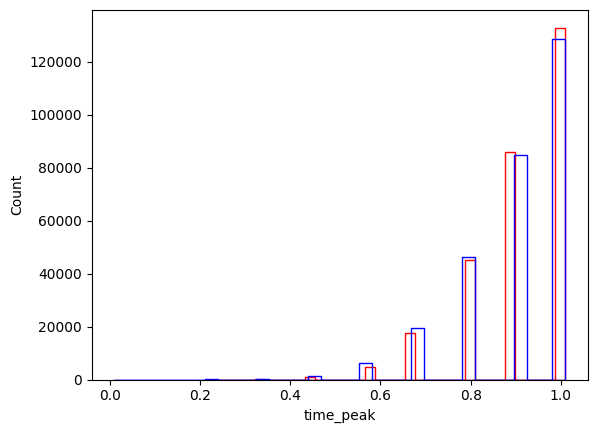

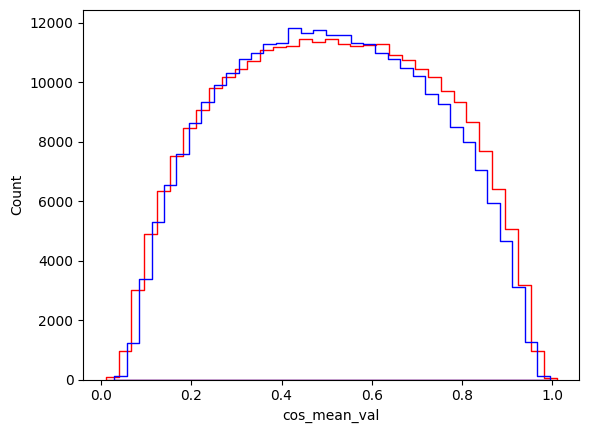

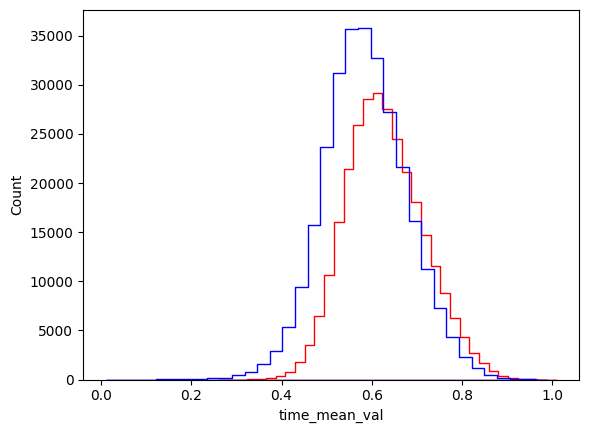

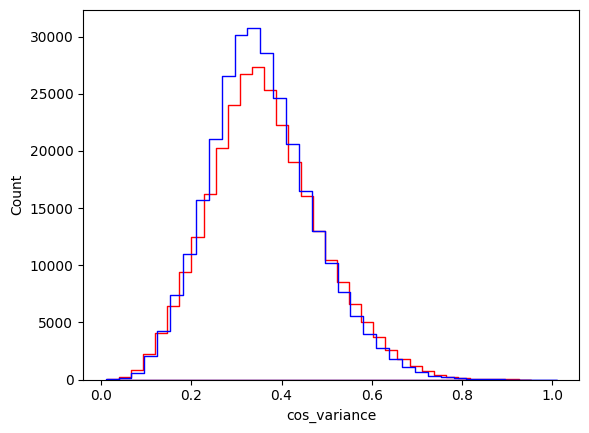

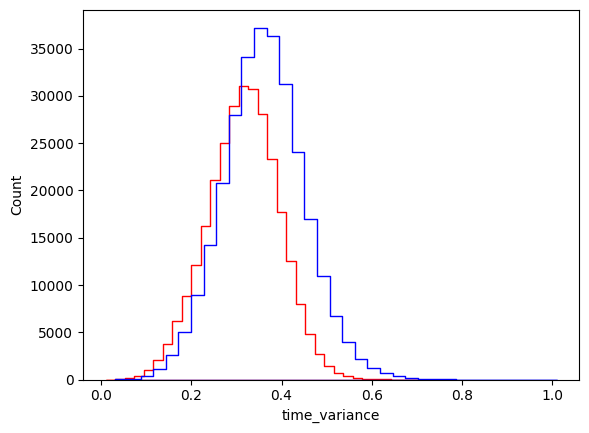

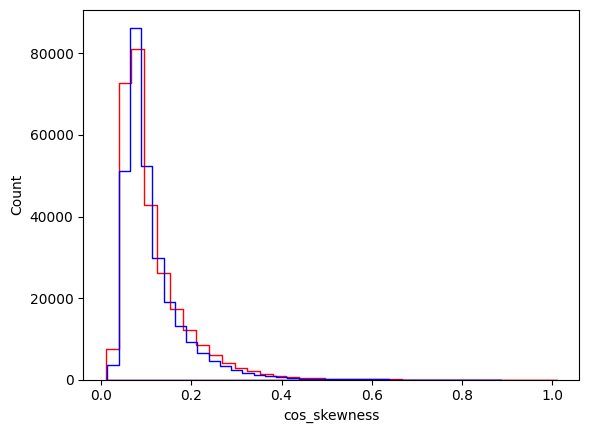

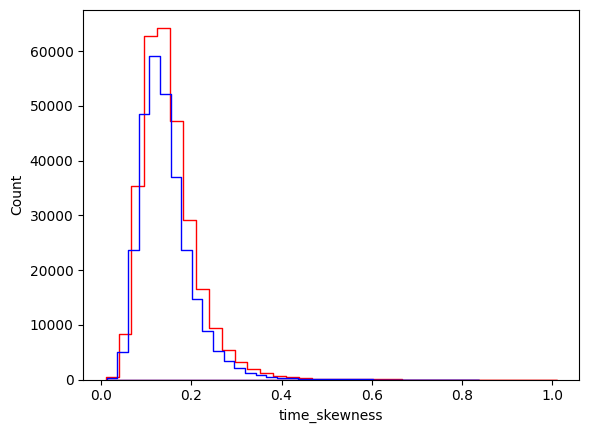

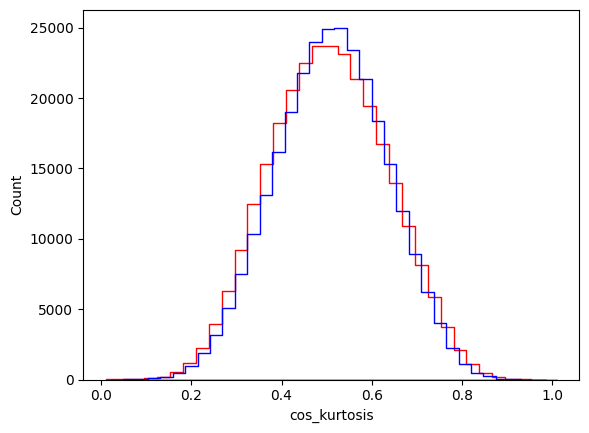

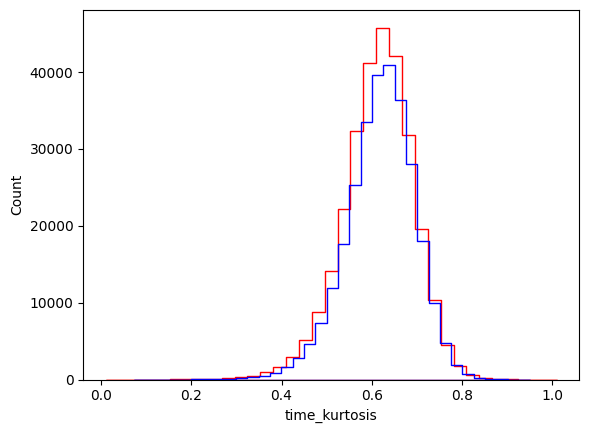

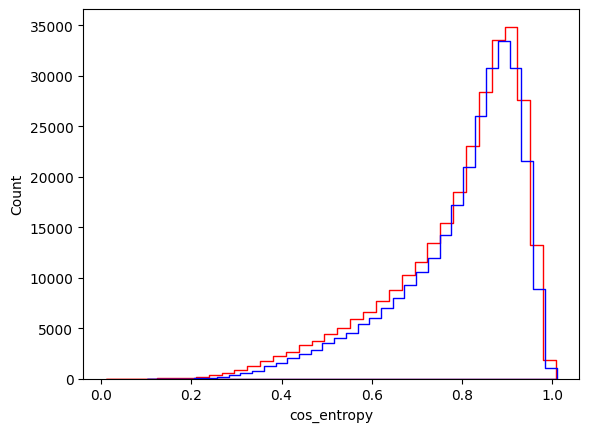

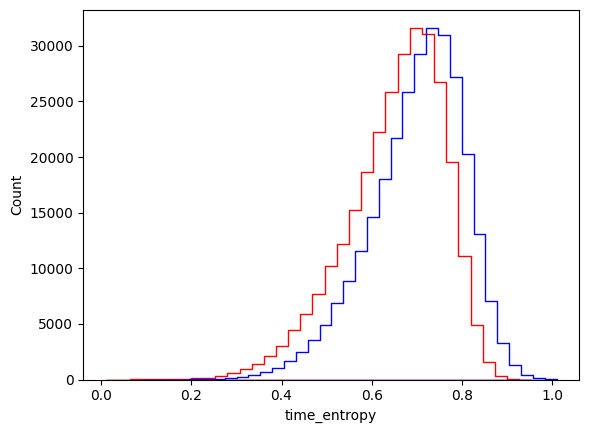

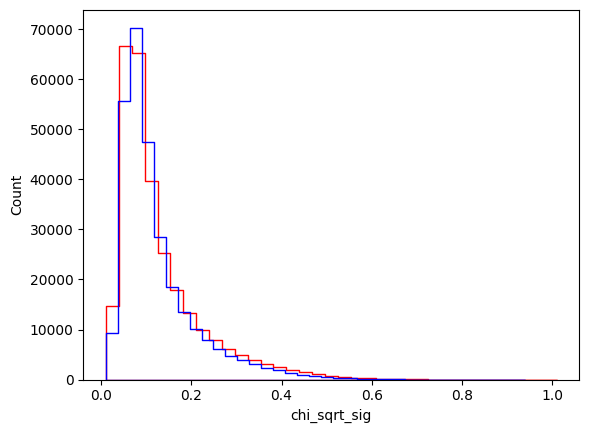

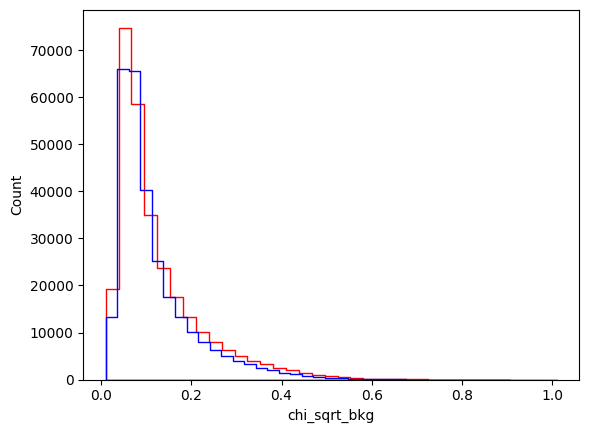

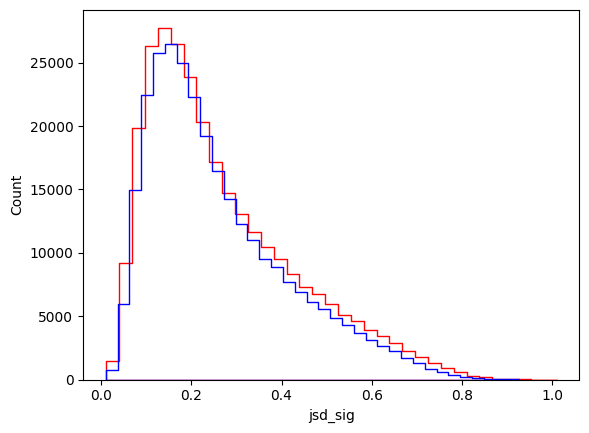

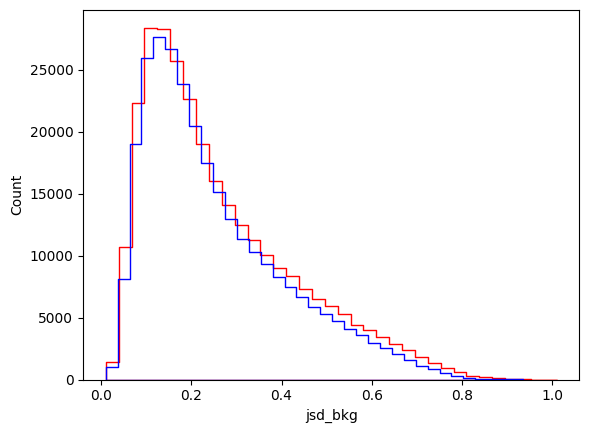

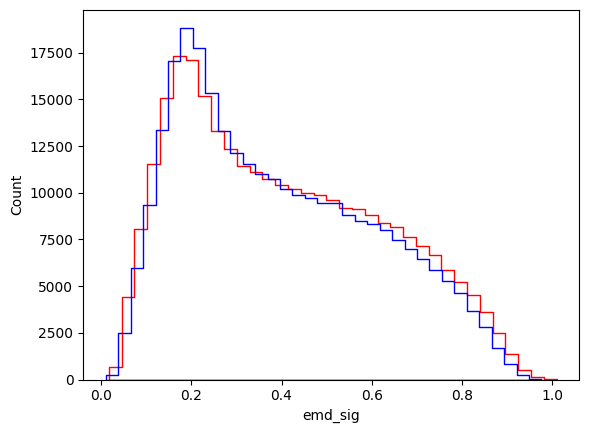

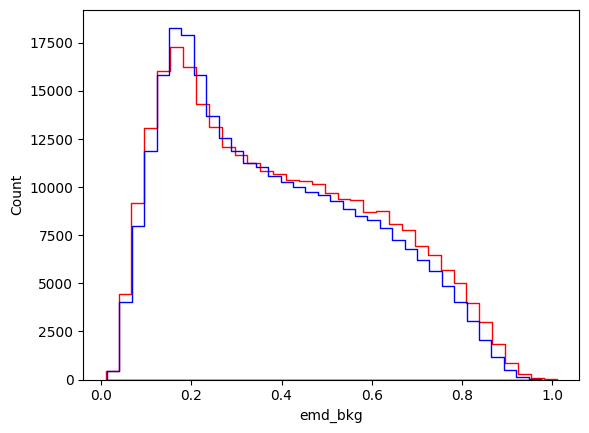

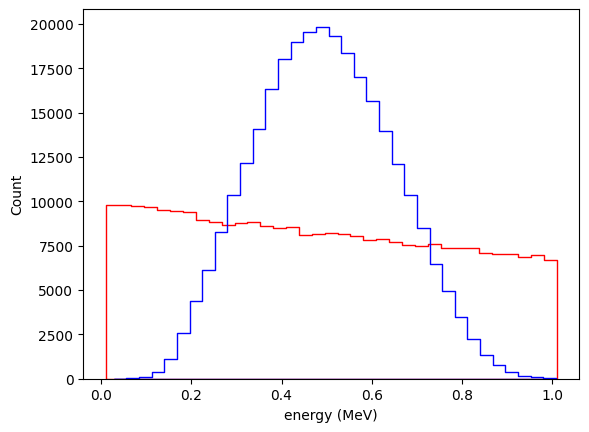

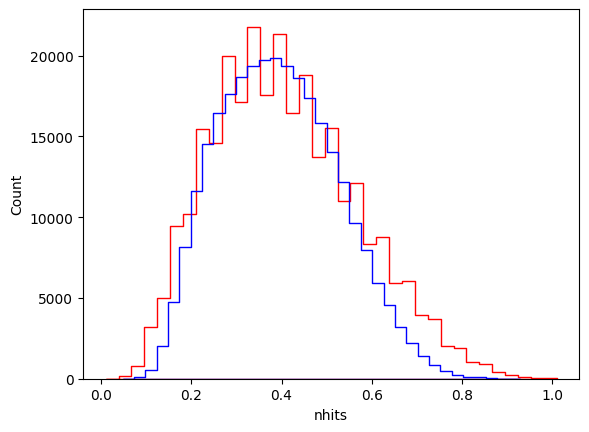

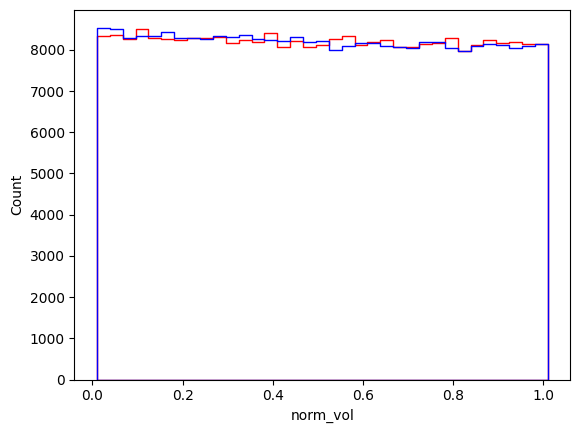

In [21]:
features_list = df_train_scaled.columns

feature_dict_sig = {feat_i : np.array(df_train_scaled[feat_i])[np.array(labels_train['IsNu'] == 1)] for feat_i in features_list}
feature_dict_bkg = {feat_i : np.array(df_train_scaled[feat_i])[np.array(labels_train['IsTl'] == 1)] for feat_i in features_list}

bins = 35
N_features = len(features_list)

for feature_i in features_list:
    
    sn.histplot(feature_dict_sig[feature_i], bins = bins, element = 'step', alpha = 0, color = 'r')
    sn.histplot(feature_dict_bkg[feature_i], bins = bins, element = 'step', alpha = 0, color = 'b')

    plt.xlabel(feature_i)
    plt.show()


# Data Split

In [14]:
df_test1_scaled, df_val_scaled, \
labels_test1, labels_val = train_test_split(df_test_scaled, labels_test, 
                                            test_size = 0.5,
                                            stratify = labels_test,
                                            random_state=42)

# Deep Learning Model Building

- Convert Pandas DataFrame to Numpy (Keras works better with numpy)

In [15]:
# -------- Data --------
X_train = df_train_scaled.to_numpy()
X_test = df_test1_scaled.to_numpy()
X_val = df_val_scaled.to_numpy()

# -------- Labels --------
labels_train = labels_train.to_numpy()
labels_test = labels_test1.to_numpy()
labels_val = labels_val.to_numpy()

# -------- Separate Sig from Bkg for test Dataset --------
mask_sig = np.array([1,0])
mask_bkg = np.array([0,1])

X_test_sig = X_test[(labels_test == mask_sig)[:,0]]
X_test_bkg = X_test[(labels_test == mask_bkg)[:,0]]

labels_test_sig = labels_test[(labels_test == mask_sig)[:,0]]
labels_test_bkg = labels_test[(labels_test == mask_bkg)[:,0]]

In [16]:
X_train.shape[1]

45

## Energy-Position One Layer Model without BatchNorm

In [58]:
n_features = X_train.shape[1]

#Model Layers and Neuron Architecture ------------------------------------------------

input_ly = Input(shape = (n_features,), name = 'input_ly')

x = Dense(40, activation = 'gelu')(input_ly)
x = Dense(38, activation = 'gelu')(x)
x = Dense(35, activation = 'gelu')(x)
x = Dense(33, activation = 'gelu')(x)
x = Dense(30, activation = 'gelu')(x)
x = Dense(28, activation = 'gelu')(x)
x = Dense(25, activation = 'gelu')(x)

x = Dropout(rate = 0.2)(x)

x = Dense(20, activation = 'gelu')(x)
x = Dense(15, activation = 'gelu')(x)
x = Dense(10, activation = 'gelu')(x)
x = Dense(7, activation = 'gelu')(x)
x = Dense(5, activation = 'gelu')(x)

output_layer = Dense(2, activation = 'sigmoid', name = 'nu_predict')(x)
#-------------------------------------------------------------------------------------

model = Model(inputs = input_ly, outputs = output_layer)

model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-5),
              loss = tf.keras.losses.BinaryCrossentropy(), 
              metrics = [tf.keras.metrics.AUC(curve='ROC', name='roc_auc'),
                         tf.keras.metrics.AUC(curve='PR', name='pr_auc'),
                         'accuracy'])


history = model.fit(x = X_train, 
                    y = labels_train, 
                    epochs = 200, 
                    batch_size = 1000,
                    validation_data=(X_val, labels_val),
                    callbacks=[tf.keras.callbacks.EarlyStopping(patience = 30, min_delta = 1e-3, monitor="val_loss")],
                    shuffle = True,
                    verbose = 1)

Epoch 1/200
575/575 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.5044 - loss: 0.6931 - pr_auc: 0.5000 - roc_auc: 0.5000 - val_accuracy: 0.5681 - val_loss: 0.6931 - val_pr_auc: 0.5000 - val_roc_auc: 0.5000
Epoch 2/200
575/575 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5507 - loss: 0.6931 - pr_auc: 0.5000 - roc_auc: 0.5000 - val_accuracy: 0.5964 - val_loss: 0.6930 - val_pr_auc: 0.5000 - val_roc_auc: 0.5000
Epoch 3/200
575/575 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5826 - loss: 0.6929 - pr_auc: 0.5090 - roc_auc: 0.5069 - val_accuracy: 0.5911 - val_loss: 0.6914 - val_pr_auc: 0.5851 - val_roc_auc: 0.6032
Epoch 4/200
575/575 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5859 - loss: 0.6893 - pr_auc: 0.5847 - roc_auc: 0.6035 - val_accuracy: 0.6354 - val_loss: 0.6723 - val_pr_auc: 0.6483 - val_roc_auc: 0.6770
Epoch 5/200
575/575 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6354 - loss: 0.6652 - pr_auc: 0.6444 - roc_auc: 0.6746 - val_accuracy: 0.6428 - val_loss: 0.6377 - val_pr

# Learning Curves

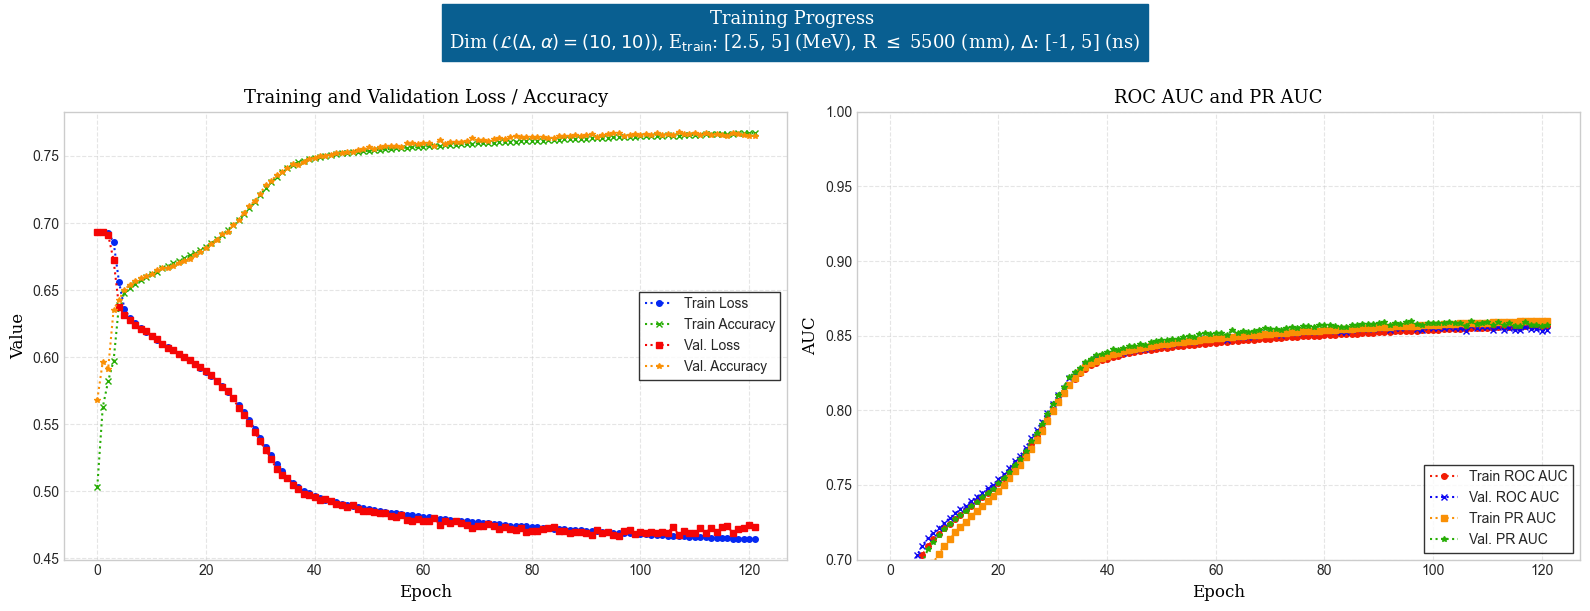

In [59]:
import matplotlib as mpl
# -------Save settings -------
save_dir = 'figs/Optimized Models/10x10/pipeline_std_minmax/'
fname = 'training_curves_'
pattern_train_save_name = f'E_{energy_inf_cut}_{energy_cut}_MeV_R_{posr_cut}_mm_Delta_({time_res_inf_cut}_{time_res_sup_cut})_ns'

# ------- Superior Title -------
main_title = 'Training Progress '
train_cut_title = rf'Dim ($\mathcal{{L}}(\Delta, \alpha) = (10,10)$), E$_\text{{train}}$: [{energy_inf_cut}, {energy_cut}] (MeV), R $\leq$ {radial_cut} (mm), $\Delta$: [{time_res_inf_cut}, {time_res_sup_cut}] (ns)'
full_title = main_title + '\n' + train_cut_title

plt.style.use('seaborn-v0_8-whitegrid')  # O prueba 'ggplot', 'seaborn-dark', etc.
font_style_title = {'family':'serif', 'weight': 'normal','color':'black','size':13}
font_style_axis= {'family':'serif', 'weight': 'normal','color':'black','size':12}

# Figura y subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# --- Plot 1: Loss & Accuracy ---
axes[0].plot(history.history['loss'], 'o:', color='#0528f2', label='Train Loss', linewidth=1.5, markersize=4)
axes[0].plot(history.history['accuracy'], 'x:', color='#27ad05', label='Train Accuracy', linewidth=1.5, markersize=4)
axes[0].plot(history.history['val_loss'], 's:', color='#f50505', label='Val. Loss', linewidth=1.5, markersize=4)
axes[0].plot(history.history['val_accuracy'], '*:', color='#fa9005', label='Val. Accuracy', linewidth=1.5, markersize=4)

axes[0].set_title('Training and Validation Loss / Accuracy', fontdict = font_style_title)
axes[0].set_xlabel('Epoch', fontdict = font_style_axis)
axes[0].set_ylabel('Value', fontdict = font_style_axis)
axes[0].legend(loc='center right', frameon=True, edgecolor='black', fancybox=False)
axes[0].grid(True, linestyle='--', alpha=0.5)

# axes[0].set_yscale('log')  # solo si realmente lo necesitas

# --- Plot 2: AUC ---
axes[1].plot(history.history['roc_auc'], 'o:', color='#f21d05', label='Train ROC AUC', linewidth=1.5, markersize=4)
axes[1].plot(history.history['val_roc_auc'], 'x:', color='#0d05f2', label='Val. ROC AUC', linewidth=1.5, markersize=4)
axes[1].plot(history.history['pr_auc'], 's:', color='#fa9005', label='Train PR AUC', linewidth=1.5, markersize=4)
axes[1].plot(history.history['val_pr_auc'], '*:', color='#27ad05', label='Val. PR AUC', linewidth=1.5, markersize=4)

axes[1].set_title('ROC AUC and PR AUC', fontdict = font_style_title)
axes[1].set_xlabel('Epoch', fontdict = font_style_axis)
axes[1].set_ylabel('AUC', fontdict = font_style_axis)
axes[1].set_ylim(0.7, 1)
axes[1].legend(loc='lower right', frameon=True, edgecolor='black', fancybox=False)
axes[1].grid(True, linestyle='--', alpha=0.5)

# axes[1].set_yscale('log')  # igual que arriba, solo si necesario

# Super título
fig.suptitle(full_title, backgroundcolor='#095f91', family = 'serif', color='white', fontsize=13, weight='normal', y=1.01)

fig.tight_layout()

# Save Plot
#if save_fig:
#    fig.savefig(save_dir + fname + pattern_train_save_name + '.png', dpi=300, bbox_inches='tight')
plt.show()

# Observation and Analysis of Predictions

## DNN Prediction

In [60]:
X_sig_pred = model.predict(X_test_sig)
X_bkg_pred = model.predict(X_test_bkg)

256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 597us/step


In [61]:
X_sig_pred

array([[0.99742216, 0.00203012],
       [0.42230618, 0.5795325 ],
       [0.9746123 , 0.02491236],
       ...,
       [0.59616846, 0.40209457],
       [0.88287896, 0.11884747],
       [0.24492747, 0.7575278 ]], dtype=float32)

## Representation of Predictions

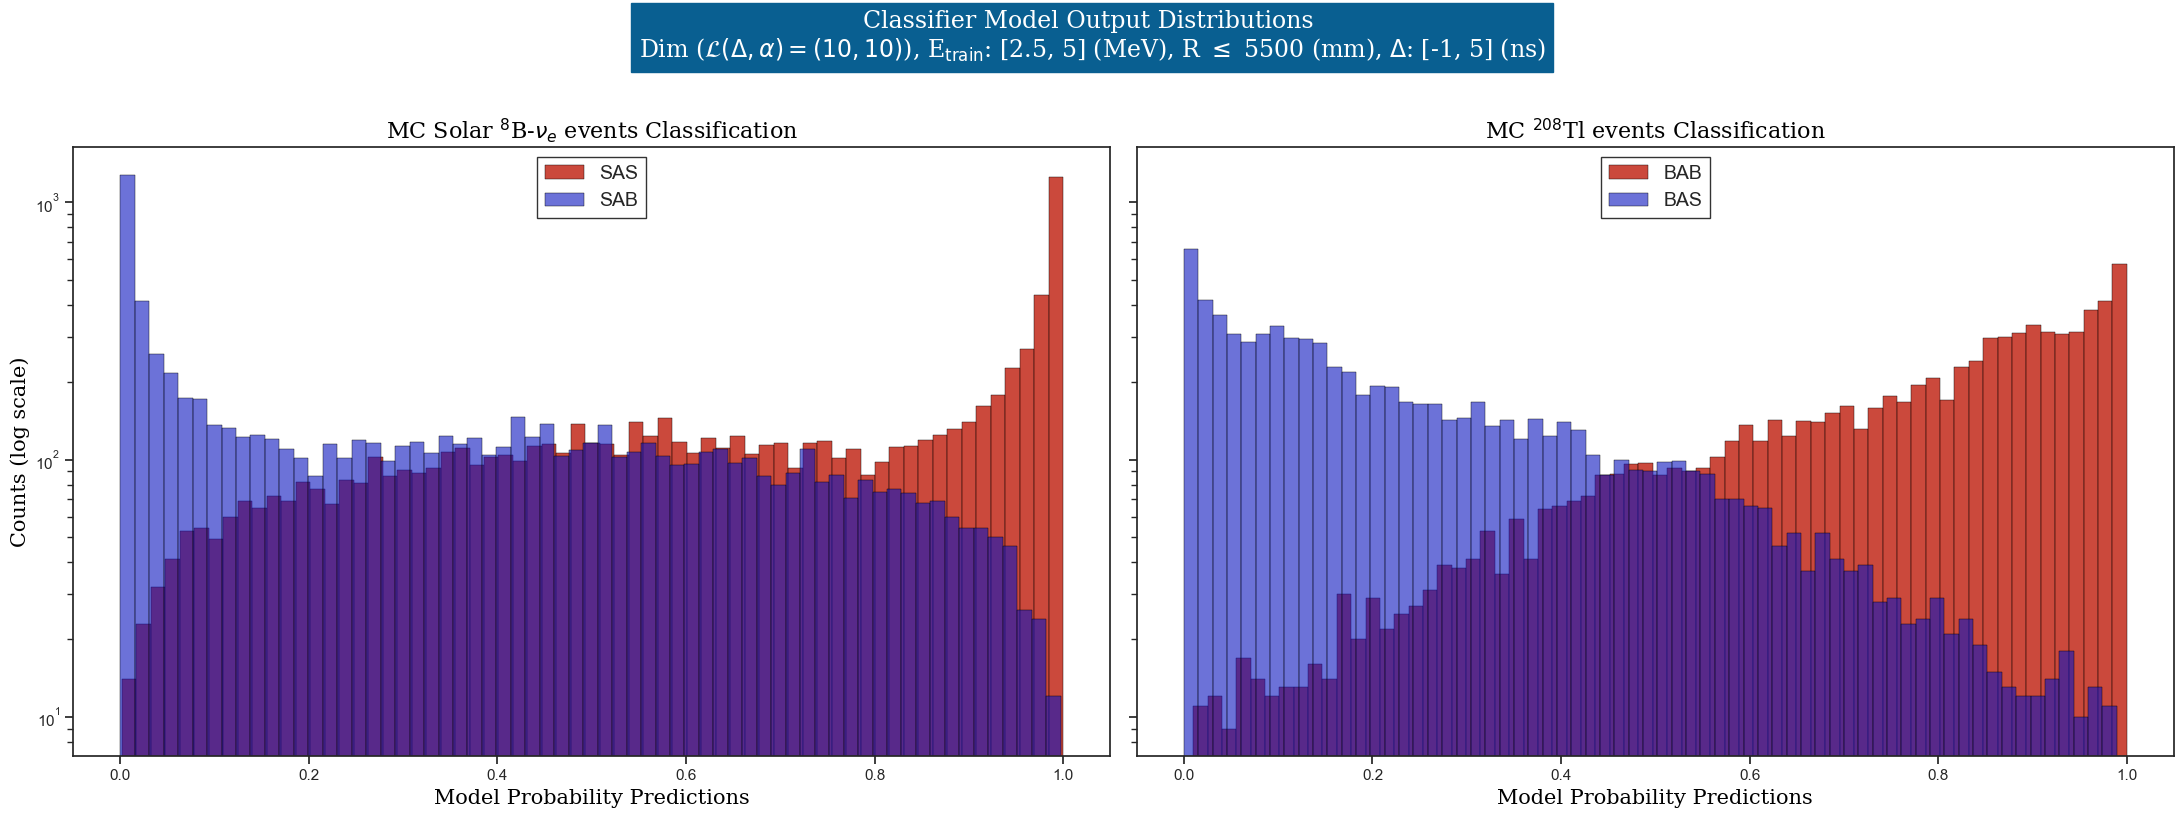

In [62]:
# ------- Save settings : -------
save_dir = 'figs/Optimized Models/10x10/pipeline_std_minmax/'
fname = 'Classifier_Model_Output_'
pattern_train_save_name = f'E_{energy_inf_cut}_{energy_cut}_MeV_R_{posr_cut}_mm_Delta_({time_res_inf_cut}_{time_res_sup_cut})_ns'

# ------- Superior Title -------
main_title = 'Classifier Model Output Distributions '
train_cut_title = rf'Dim ($\mathcal{{L}}(\Delta, \alpha) = (10,10)$), E$_\text{{train}}$: [{energy_inf_cut}, {energy_cut}] (MeV), R $\leq$ {radial_cut} (mm), $\Delta$: [{time_res_inf_cut}, {time_res_sup_cut}] (ns)'
full_title = main_title + '\n' + train_cut_title

sn.set_theme(style="ticks")  # o "ticks", "darkgrid", etc.
font_style_title = {'family':'serif', 'weight': 'normal','color':'black','size':16}
font_style_axis= {'family':'serif', 'weight': 'normal','color':'black','size':15}

bins = 65
fig, axes = plt.subplots(1, 2, figsize=(22, 8), sharey=True)

# Solar ν predictions
sn.histplot(X_sig_pred[:, 0], bins=bins, label='SAS', color='#bf1c0b',
             edgecolor='black', linewidth=0.3, alpha=0.8, ax=axes[0])
sn.histplot(X_sig_pred[:, 1], bins=bins, label='SAB', color='#0b14bf',
             edgecolor='black', linewidth=0.3, alpha=0.6, ax=axes[0])

# Background predictions
sn.histplot(X_bkg_pred[:, 1], bins=bins, label='BAB', color='#bf1c0b',
             edgecolor='black', linewidth=0.3, alpha=0.8, ax=axes[1])
sn.histplot(X_bkg_pred[:, 0], bins=bins, label='BAS', color='#0b14bf',
             edgecolor='black', linewidth=0.3, alpha=0.6, ax=axes[1])

# Titles and labels
axes[0].set_title('MC Solar $^8$B-$\\nu_e$ events Classification', fontdict = font_style_title)
axes[0].set_xlabel('Model Probability Predictions', fontdict = font_style_axis)
axes[0].set_ylabel('Counts (log scale)', fontdict = font_style_axis)
axes[0].legend(loc = 'best', frameon=True, edgecolor='black', fancybox=False, fontsize=14)
axes[0].set_yscale('log')

axes[1].set_title('MC $^{208}$Tl events Classification', fontdict = font_style_title)
axes[1].set_xlabel('Model Probability Predictions', fontdict = font_style_axis)
axes[1].set_ylabel('Counts (log scale)', fontdict = font_style_axis)
axes[1].legend(loc = 'upper center', frameon=True, edgecolor='black', fancybox=False, fontsize=14)
axes[1].set_yscale('log')

# General formatting
plt.suptitle(full_title, backgroundcolor='#095f91', family = 'serif', color='white', fontsize=17, weight='normal', y=1.02)

plt.tight_layout()
#if save_fig:
#    fig.savefig(save_dir + fname + pattern_train_save_name + '.png', dpi=300, bbox_inches='tight')
plt.show()

### ROC and PR Curves

In [63]:
X_pred = np.concatenate((X_sig_pred, X_bkg_pred))              #Predicted
X_exp = np.concatenate((labels_test_sig, labels_test_bkg))     #Expected

# ====================== ROC Calculation ======================
fpr_sig, tpr_sig, _ = roc_curve(X_exp[:,0], X_pred[:,0])
auc_sig = auc(fpr_sig, tpr_sig)

fpr_bkg, tpr_bkg, _ = roc_curve(X_exp[:,1], X_pred[:,1])
auc_bkg = auc(fpr_bkg, tpr_bkg)

fpr_all, tpr_all, _ = roc_curve(
    np.concatenate((X_exp[:,0], X_exp[:,1])),
    np.concatenate((X_pred[:,0], X_pred[:,1]))
)
auc_all = auc(fpr_all, tpr_all)

# ====================== PR Calculation ======================
prec_sig, rec_sig, _ = precision_recall_curve(X_exp[:,0], X_pred[:,0])
pr_auc_sig = auc(rec_sig, prec_sig)
N_positive = X_sig_pred.shape[0]
N_samples = X_sig_pred.shape[0] + X_bkg_pred.shape[0]
random_guess_line = N_positive/N_samples  #The random guess line is given by an horizontal line in the precision coordinate = (Nº of positive smaples)/(Nº of samples)

prec_bkg, rec_bkg, _ = precision_recall_curve(X_exp[:,1], X_pred[:,1])
pr_auc_bkg = auc(rec_bkg, prec_bkg)

prec_all, rec_all, _ = precision_recall_curve(
    np.concatenate((X_exp[:,0], X_exp[:,1])),
    np.concatenate((X_pred[:,0], X_pred[:,1]))
)
pr_auc_all = auc(rec_all, prec_all)

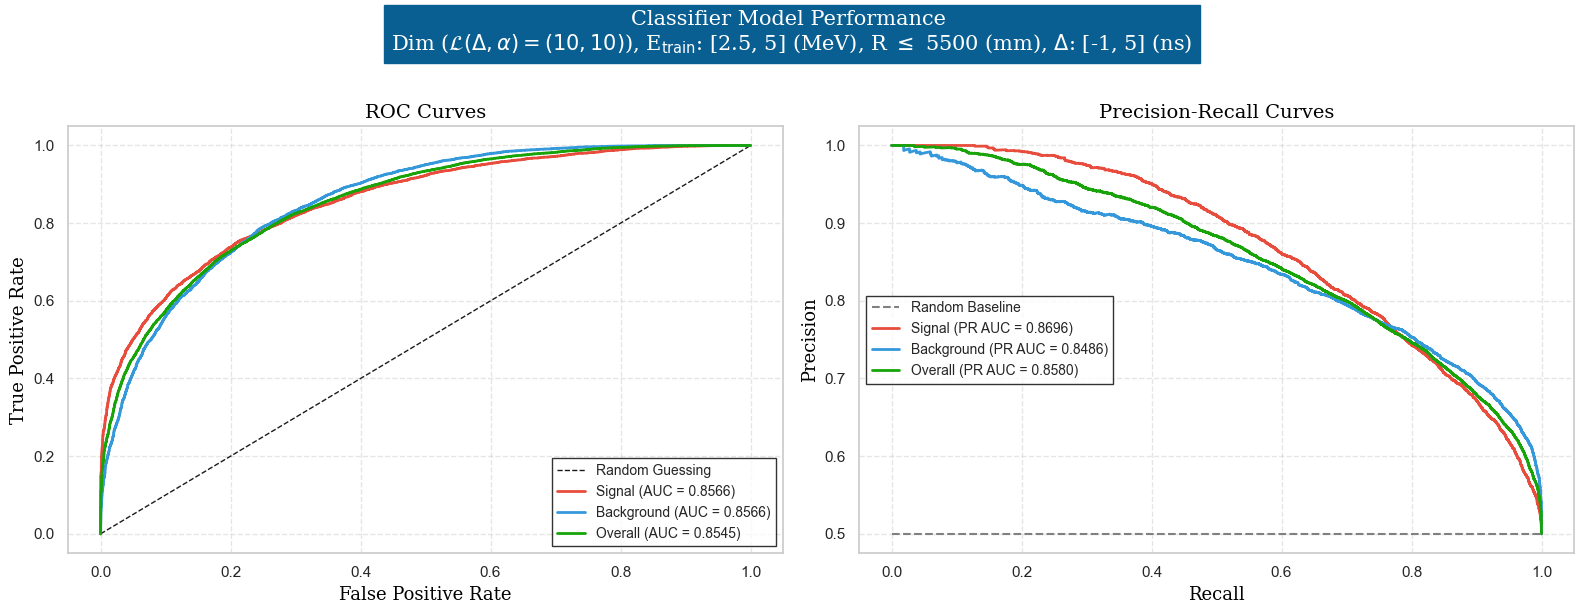

In [64]:
# ------- Save settings : -------
save_dir = 'figs/Optimized Models/10x10/pipeline_std_minmax/'
fname = 'ROC_PR_'
pattern_train_save_name = f'E_{energy_inf_cut}_{energy_cut}_MeV_R_{posr_cut}_mm_Delta_({time_res_inf_cut}_{time_res_sup_cut})_ns'

# ------- Superior Title -------
main_title = 'Classifier Model Performance '
train_cut_title = rf'Dim ($\mathcal{{L}}(\Delta, \alpha) = (10,10)$), E$_\text{{train}}$: [{energy_inf_cut}, {energy_cut}] (MeV), R $\leq$ {radial_cut} (mm), $\Delta$: [{time_res_inf_cut}, {time_res_sup_cut}] (ns)'
full_title = main_title + '\n' + train_cut_title

sn.set_theme(style="whitegrid")
font_style_title = {'family':'serif', 'weight': 'normal','color':'black','size':14}
font_style_axis  = {'family':'serif', 'weight': 'normal','color':'black','size':13}

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# ---------- Subplot 1: ROC para sig, bkg y overall ----------
axes[0].plot([0, 1], [0, 1], 'k--', label='Random Guessing', linewidth=1)
axes[0].plot(fpr_sig, tpr_sig, color='#e74c3c', linewidth=2,
             label=f'Signal (AUC = {auc_sig:.4f})')
axes[0].plot(fpr_bkg, tpr_bkg, color='#3498db', linewidth=2,
             label=f'Background (AUC = {auc_bkg:.4f})')
axes[0].plot(fpr_all, tpr_all, color='#18a308', linewidth=2,
             label=f'Overall (AUC = {auc_all:.4f})')

axes[0].set_title('ROC Curves', fontdict=font_style_title)
axes[0].set_xlabel('False Positive Rate', fontdict=font_style_axis)
axes[0].set_ylabel('True Positive Rate', fontdict=font_style_axis)
axes[0].legend(loc='lower right', frameon=True, edgecolor='black', fancybox=False, fontsize=10)
axes[0].grid(True, linestyle='--', alpha=0.5)

# ---------- Subplot 2: Precision-Recall para sig, bkg y overall ----------
axes[1].hlines(random_guess_line, 0, 1, colors="gray", linestyles="--", label="Random Baseline")
axes[1].plot(rec_sig, prec_sig, color='#e74c3c', linewidth=2,
             label=f'Signal (PR AUC = {pr_auc_sig:.4f})')
axes[1].plot(rec_bkg, prec_bkg, color='#3498db', linewidth=2,
             label=f'Background (PR AUC = {pr_auc_bkg:.4f})')
axes[1].plot(rec_all, prec_all, color='#18a308', linewidth=2,
             label=f'Overall (PR AUC = {pr_auc_all:.4f})')

axes[1].set_title('Precision-Recall Curves', fontdict=font_style_title)
axes[1].set_xlabel('Recall', fontdict=font_style_axis)
axes[1].set_ylabel('Precision', fontdict=font_style_axis)
axes[1].legend(loc='center left', frameon=True, edgecolor='black', fancybox=False, fontsize=10)
axes[1].grid(True, linestyle='--', alpha=0.5)

# --------- Título general ---------
fig.suptitle(full_title, backgroundcolor='#095f91', family = 'serif', color='white', fontsize=15, weight='normal', y=1.02)

plt.tight_layout()
#if save_fig:
#    fig.savefig(save_dir + fname + pattern_train_save_name + '.png', dpi=300, bbox_inches='tight')
plt.show()

###  Reconstrucción de espector de solar $ν_e$ y de Tálio

Seran seleccionados unicamente energias de eventos de neutrinos solar con un predicción X_pred[:,0] > threshold para ver que tan bueno se reconstruye el espectro de neutrinos solares. Los mismo para eventos de Tálio. Asi, podra ser observado en que energias el modelo tiene mas dificultades en acertar predicciones

In [65]:
# ==== Reconstruct the original test1 dataset ====

original_data_test = scaling_pipeline_test.inverse_transform(df_test1_scaled)

original_data_test_sig = original_data_test[(labels_test == mask_sig)[:,0]]
original_data_test_bkg = original_data_test[(labels_test == mask_bkg)[:,0]]

# Separate sig. and bkg components:
original_data_test_sig = pd.DataFrame(original_data_test_sig, columns = df_test1_scaled.columns)
original_data_test_bkg = pd.DataFrame(original_data_test_bkg, columns = df_test1_scaled.columns)

# Extract physical observables of interest to analyze the model performance:

energy_sig_rc = original_data_test_sig['energy (MeV)'].to_numpy()
energy_bkg_rc = original_data_test_bkg['energy (MeV)'].to_numpy()

norm_vol_sig_rc = original_data_test_sig['norm_vol'].to_numpy()
norm_vol_bkg_rc = original_data_test_bkg['norm_vol'].to_numpy()

vol = posr_cut**3

radi_sig_rc = np.cbrt(norm_vol_sig_rc*vol)
radi_bkg_rc = np.cbrt(norm_vol_bkg_rc*vol)

### Normalized Efficiency by N_Counts(true)

Construir un plot de eficicencia normalizada por el numero total de eventos en un bin del plot "Separated Spectrums for Threshold (trh)".
Procedimientos de construcción:

1) extraer valores de energia contenidos en cada bin de "Separated Spectrums for Threshold (trh)"
2) Contabilizar el nº de eventos que superan el treshold dentro del bin de energia, y dividir por el número de eventos contenido en el bin, esta será la eficiencia normalizado por N_events_true
3) Hacer plot de la eficiciencia normalizada en funcion del valor medio de las energias contenida en el bin (cuanto mas bins, mas puntos de eficiencia habra)

#### Graficos de Energia Reconstruida y de Eficiencia Normalizada para varios Threshold de Predicción del Modelo

##### Extraer Información para los Gráficos

In [66]:
#Idea: A cada loop de thr, agregar a las listas arrays de energia reconstruida y de eficiciencia normalizada, asi cada indice de lista corresponde a un thr

bins_nu = 15             #-> Define how many intervals in energy. Equals to the number of point of norm_eff. PREDEFINED BINS = 20
bins_tl = 8              #-> BINS = 8

thr = [0.90, 0.80, 0.70, 0.60]  #-> Define the thresholds

prob_sas = X_sig_pred[:,0]      #probiblity of the event of neutrino being detected as neutrino
#prob_bab = X_bkg_pred[:,1]      #probiblity of the event of thallium being detected as thallium
prob_bas = X_bkg_pred[:,0]      #probiblity of the event of thallium being detected as neutrino

en_sig_test_count, en_sig_test_edge = np.histogram(energy_sig_rc, bins = bins_nu)   #Extract interval of binned data
en_bkg_test_count, en_bkg_test_edge = np.histogram(energy_bkg_rc, bins = bins_tl)   #Extract interval of binned data

# Extract the binwidth - Expresion only valid for constant binning!
binwidth_en_sig = en_sig_test_edge[2] - en_sig_test_edge[1]  
binwidth_en_bkg = en_bkg_test_edge[2] - en_bkg_test_edge[1]


N_edges_sig = len(en_sig_test_edge)
N_edges_bkg = len(en_bkg_test_edge)

#Information to extract--------------------------------------
nu_energy_in_sas = []
#nu_energy_out_sas = []

tl_energy_in_bas = []
#tl_energy_out_bab = []

#mean normalized eficiency values for signal as signal and bkg as sig
norm_eff_sig_in_sas = []
norm_eff_bkg_in_bas = []

norm_eff_bkg = []

#mean energy within each bin for signal and bkg data
mean_energy_sig = []  
mean_energy_bkg = []   

for thr_i in thr: 

    #Information to save in each loop of threshold --------------
    nu_energy_in_sas_thr = []
    #nu_energy_out_sas_thr = []
    
    tl_energy_in_bas_thr = []
    #tl_energy_out_bas_thr = []

    #normalized eficiency values for signal and bkg for each thr
    #Used to contruct the norm eff plot
    norm_eff_sig_in_sas_thr = np.array([])
    norm_eff_bkg_in_bas_thr = np.array([])

    #mean energy within each bin for signal and bkg data for each thr (aunque acaba siendo el mismo valor medio para cado thr y para los histogramas que preservan el número de bins).
    #Used to contruct the norm eff plot
    mean_energy_sig_thr = np.array([]) 
    mean_energy_bkg_thr = np.array([]) 

    #mean radial values within each bin for signal and bkg data for each thr
    #Used to contruct the norm eff plot
    mean_rad_sig_thr = np.array([]) 
    mean_rad_bkg_thr = np.array([]) 
    
    #----------------------------------------------

    #Extract info for Plot of energy > thr and energy < thr

    #Extract
    for i in np.where(prob_sas >= thr_i)[0]:
        nu_energy_in_sas_thr.append(energy_sig_rc[i])
        
    #for j in np.where(prob_sas < thr_i)[0]:
        #nu_energy_out_sas_thr.append(energy_sig_rc[j])
    
    for m in np.where(prob_bas >= thr_i)[0]:
        tl_energy_in_bas_thr.append(energy_bkg_rc[m])
    
    #for k in np.where(prob_bab < thr_i)[0]:
        #tl_energy_out_spectrum_thr.append(energy_bkg_rc[k])
        
    nu_energy_in_sas.append(np.array(nu_energy_in_sas_thr))
    #nu_energy_out_sas.append(np.array(nu_energy_out_sas_thr))
    tl_energy_in_bas.append(np.array(tl_energy_in_bas_thr))
    #tl_energy_out_bab.append(np.array(tl_energy_out_spectrum_thr))

    #Extract norm_eff and mean nu enery within each bin:
    #1) Extract for solar nu event predictions
    for i in range(N_edges_sig-1):
        #extract edges value of energy at each bin
        energy_edge_i = en_sig_test_edge[i]
        energy_edge_f = en_sig_test_edge[i+1]
    
        #find energy in energy_test_sig between edges values and the model prediction for SAS 
        energy_interval = np.extract((energy_sig_rc >= energy_edge_i) & (energy_sig_rc <= energy_edge_f), energy_sig_rc)
        prob_sas_interval = np.extract((energy_sig_rc >= energy_edge_i) & (energy_sig_rc <= energy_edge_f), prob_sas)
    
        #extract mean energy of binned interval
        mean_energy_interval = np.mean(energy_interval)
        
        mean_energy_sig_thr = np.append(mean_energy_sig_thr, mean_energy_interval)
        
        #Total Number of events we know are true
        N_true = len(prob_sas_interval)
    
        #find where prob. is higher than threshold and count
        condition_thr = prob_sas_interval >= thr_i
        energy_up_thr = np.extract(condition_thr, energy_interval)
        N_up_thr = len(energy_up_thr)
    
        #compute and extract normalized efficiency
        norm_eff_interval = N_up_thr / N_true
        norm_eff_sig_in_sas_thr = np.append(norm_eff_sig_in_sas_thr, norm_eff_interval)

    norm_eff_sig_in_sas.append(norm_eff_sig_in_sas_thr)
    mean_energy_sig.append(mean_energy_sig_thr)
        
    #2) Extract for Tl event predictions
    for i in range(N_edges_bkg-1):
        #extract edges value of energy at each bin
        energy_edge_i = en_bkg_test_edge[i]
        energy_edge_f = en_bkg_test_edge[i+1]
    
        #find energy in energy_test_bkg between edges values and the model prediction for BAS
        energy_interval = np.extract((energy_bkg_rc >= energy_edge_i) & (energy_bkg_rc <= energy_edge_f), energy_bkg_rc)
        prob_bas_interval = np.extract((energy_bkg_rc >= energy_edge_i) & (energy_bkg_rc <= energy_edge_f), prob_bas)
    
        #extract mean energy of binned interval
        mean_energy_interval = np.mean(energy_interval)
        
        mean_energy_bkg_thr = np.append(mean_energy_bkg_thr, mean_energy_interval)
        
        #Total Number of events we know are true
        N_true = len(prob_bas_interval)
    
        #find where prob. is higher than threshold and count
        condition_thr = prob_bas_interval >= thr_i
        energy_up_thr = np.extract(condition_thr, energy_interval)
        N_up_thr = len(energy_up_thr)
    
        #compute and extract normalized efficiency
        norm_eff_interval = N_up_thr / N_true
        norm_eff_bkg_in_bas_thr = np.append(norm_eff_bkg_in_bas_thr, norm_eff_interval)
    
    norm_eff_bkg_in_bas.append(norm_eff_bkg_in_bas_thr)
    mean_energy_bkg.append(mean_energy_bkg_thr)

#Transform lists to array where each arrow correspond to the values of (energy, norm_eff) for a certain thr
mean_energy_sig = np.array(mean_energy_sig)
norm_eff_sig_in_sas = np.array(norm_eff_sig_in_sas)

mean_energy_bkg = np.array(mean_energy_bkg)
norm_eff_bkg_in_bas = np.array(norm_eff_bkg_in_bas)

#### Construir los Gráficos

- Energia

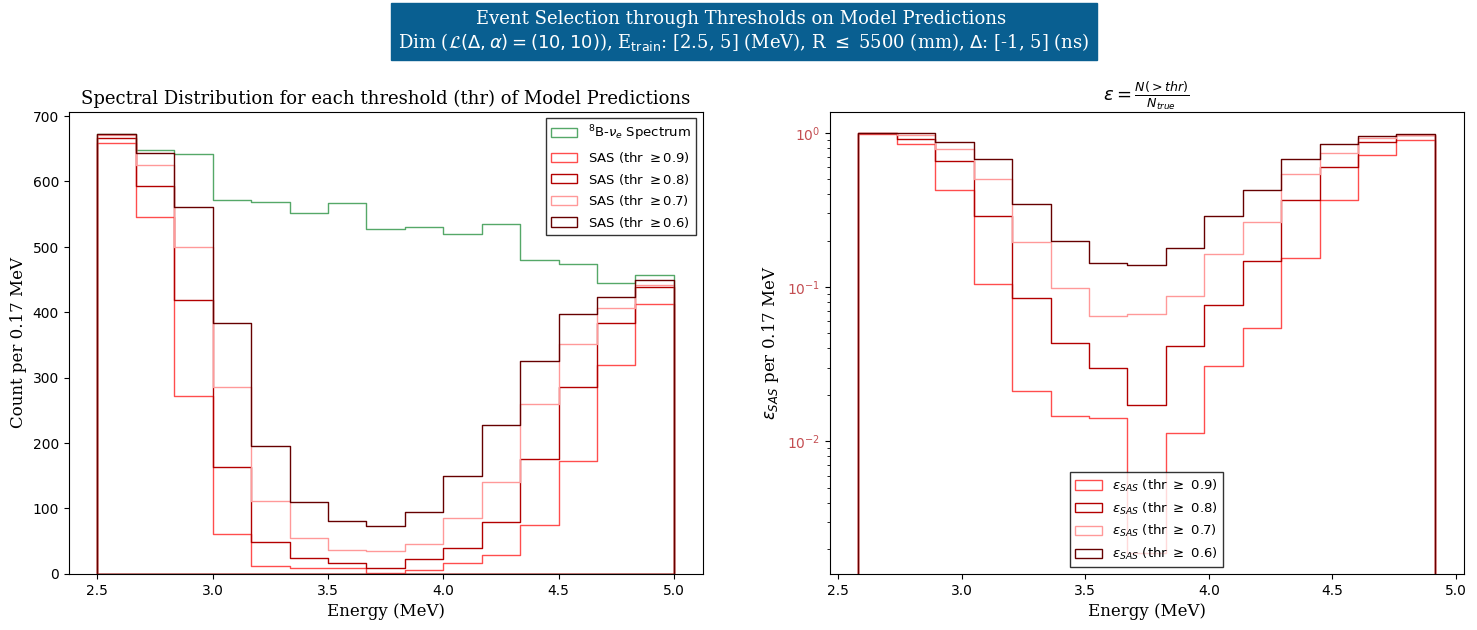

In [67]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
sn.reset_orig

# ------- Save settings : -------
save_dir = 'figs/Optimized Models/10x10/pipeline_std_minmax/'
fname = 'classified_ev_energy_per_and_eff_per_thr'
pattern_train_save_name = f'E_{energy_inf_cut}_{energy_cut}_MeV_R_{posr_cut}_mm_Delta_({time_res_inf_cut}_{time_res_sup_cut})_ns'

# ------- Superior Title -------
main_title = 'Event Selection through Thresholds on Model Predictions '
train_cut_title = rf'Dim ($\mathcal{{L}}(\Delta, \alpha) = (10,10)$), E$_\text{{train}}$: [{energy_inf_cut}, {energy_cut}] (MeV), R $\leq$ {radial_cut} (mm), $\Delta$: [{time_res_inf_cut}, {time_res_sup_cut}] (ns)'
full_title = main_title + '\n' + train_cut_title

# ------- Font Styles -------
font_style_title = {'family':'serif', 'weight': 'normal','color':'black','size':13}
font_style_axis  = {'family':'serif', 'weight': 'normal','color':'black','size':12}

bas_on = False
alpha = 0

#main plot: Test Solar Energy
fig, axes = plt.subplots(1,2, figsize =(18, 6)) 

sn.histplot(energy_sig_rc, ax = axes[0], bins = bins_nu, color = 'g' , label = r'$^8$B-$ν_e$ Spectrum', alpha = alpha, element = 'step')

for i_dx, thr_i in enumerate(thr):  
    #Sig Spectral distribution
    sn.histplot(nu_energy_in_sas[i_dx], ax = axes[0], bins = bins_nu, color = red_variants[i_dx] , label = r'SAS (thr $\geq$'+str(thr_i)+')', 
                alpha = alpha, element = 'step')

    #Sig Efficiency normalized by N_true counts
    sn.histplot(x = mean_energy_sig[i_dx], ax = axes[1], bins=len(mean_energy_sig[i_dx]), color = red_variants[i_dx], 
                weights=norm_eff_sig_in_sas[i_dx], element = 'step', alpha = 0.0, label = r'$\epsilon_{SAS}$ (thr $\geq$ '+str(thr_i)+')')

    if bas_on:
        #bkg spectra
        sn.histplot(tl_energy_in_bas[i_dx], ax = axes[0], bins = bins_tl, color = blue_variants[i_dx] , label = r'BAS (thr $\geq$'+str(thr_i)+')', 
                    alpha = alpha, element = 'step')

        #bkg efficiency
        ax1_1 = axes[1].twinx()  #Right axis for the norm_eff plot due to differences between eff scales
        sn.histplot(x = mean_energy_bkg[i_dx], ax = ax1_1, bins=len(mean_energy_bkg[i_dx]), color = blue_variants[i_dx], 
                    weights=norm_eff_bkg_in_bas[i_dx], element = 'step', alpha = 0.0, label = r'$\epsilon_{BAS}$ (thr $\geq$ '+str(thr_i)+')')

        ax1_1.legend(loc = 'upper right')
        ax1_1.set_ylabel(r'$\epsilon_{BAS}$', fontdict=font_style_axis)
        ax1_1.tick_params(axis='y', labelcolor='b')
        

axes[0].set_title(r'Spectral Distribution for each threshold (thr) of Model Predictions', fontdict=font_style_title)
axes[0].set_xlabel('Energy (MeV)', fontdict=font_style_axis)
axes[0].set_ylabel(f'Count per {binwidth_en_sig:.2f} MeV', fontdict=font_style_axis)
axes[0].legend(loc = 'upper right', frameon=True, edgecolor='black', fancybox=False, fontsize=9.5)
#axes[0].set_yscale('log')

axes[1].set_title(r'$\epsilon = \frac{N(>thr)}{N_{true}}$', fontdict=font_style_title)
axes[1].set_xlabel('Energy (MeV)', fontdict=font_style_axis)
axes[1].set_ylabel(rf'$\epsilon_{{SAS}}$ per {binwidth_en_sig:.2f} MeV', fontdict=font_style_axis)
axes[1].legend(loc = 'lower center', frameon=True, edgecolor='black', fancybox=False, fontsize=9.5)
axes[1].tick_params(axis='y', labelcolor='r')
axes[1].set_yscale('log')

plt.suptitle(full_title, backgroundcolor='#095f91', family = 'serif', color='white', fontsize=13, weight='normal', y=1.05)

#if save_fig:
#    fig.savefig(save_dir + fname + pattern_train_save_name + '.png', dpi=300, bbox_inches='tight')
    
plt.show()

In [68]:
# Mean eficiency calculation in [2.5,10] for each thr in SAS

mean_eff = []  # List with the values of the mean efficicency for each threshold in energy within a range [2.5,10] MeV
eff_error = [] # list with the error value associated to hte mean_eff by the maximum desviation.
results = []   # List with explicit result of the thr and mean value of efficiency

for i_dx, thr_i in enumerate(thr):

    eff_sas_thr = norm_eff_sig_in_sas[i_dx]
    energy_sas_thr = mean_energy_sig[i_dx]
    
    #Extract the values of efficiency which verifies the energy cut
    condition = (energy_sas_thr <= 10)
    eff_sas_filter = np.extract(condition, eff_sas_thr)

    #Obtain mean value as the mean percentage of events in thr which are truly solar nu
    mean_eff_sas_thr = np.mean(eff_sas_filter, dtype = np.float16)
    mean_eff.append(mean_eff_sas_thr)

    #Compute the eff error by the maximum deviation of the samples from the mean value
    deviations = abs(eff_sas_thr -  mean_eff_sas_thr)
    max_deviation = np.max(deviations)
    eff_error.append(max_deviation)

    result_thr = 'For thr='+str(thr_i) + r', the eff for SAS is = ' + str(mean_eff_sas_thr) + ' with an error of ' + str(max_deviation)
    results.append(result_thr)

In [69]:
results

['For thr=0.9, the eff for SAS is = 0.3093 with an error of 0.6698714507104383',
 'For thr=0.8, the eff for SAS is = 0.4053 with an error of 0.5858112578937593',
 'For thr=0.7, the eff for SAS is = 0.4895 with an error of 0.5075262786729198',
 'For thr=0.6, the eff for SAS is = 0.5806 with an error of 0.44204648215132825']

- Radius

In [70]:
#Idea: A cada loop de thr, agregar a las listas arrays de energia reconstruida y de eficiciencia normalizada, asi cada indice de lista corresponde a un thr

bins_rad = 20            #-> BINS = 20
thr = [0.95, 0.8, 0.70]  #-> Define the thresholds

prob_sas = X_sig_pred[:,0]
prob_bas = X_bkg_pred[:,0]

rad_sig_test_count, rad_sig_test_edge = np.histogram(radi_sig_rc, bins = bins_rad)
rad_bkg_test_count, rad_bkg_test_edge = np.histogram(radi_bkg_rc, bins = bins_rad)

N_edges= len(rad_sig_test_edge)

#mean normalized eficiency values for signal and bkg
norm_eff_sig_in_sas = []
norm_eff_bkg_in_bas = []  

#mean radial values within each bin for signal and bkg data
mean_rad_sig = []
mean_rad_bkg = []

for thr_i in thr: 

    #mean normalized eficiency values for signal and bkg for each thr
    norm_eff_sig_in_sas_thr = np.array([])
    norm_eff_bkg_in_bas_thr = np.array([])
    
    #mean radial values within each bin for signal and bkg data for each thr
    mean_rad_sig_thr = np.array([]) 
    mean_rad_bkg_thr = np.array([]) 
    
    #----------------------------------------------

    #Extract norm_eff and mean radius within each bin:
    #1) Extract for solar nu event predictions
    for i in range(N_edges-1):
        #extract edges value of energy at each bin
        radi_edge_i = rad_sig_test_edge[i]
        radi_edge_f = rad_sig_test_edge[i+1]
    
        #find energy in energy_test_sig and energy_test_bkg between edges values is and the model prediction
        radi_interval = np.extract((radi_sig_rc >= radi_edge_i) & (radi_sig_rc <= radi_edge_f), radi_sig_rc)
        prob_sas_interval = np.extract((radi_sig_rc >= radi_edge_i) & (radi_sig_rc <= radi_edge_f), prob_sas)
    
        #extract and save the mean radi of binned interval
        mean_rad_interval = np.mean(radi_interval)
        mean_rad_sig_thr = np.append(mean_rad_sig_thr, mean_rad_interval)
        
        #Total Number of events we know are true
        N_true = len(prob_sas_interval)
    
        #find where prob. is higher than threshold and count
        condition_thr = prob_sas_interval >= thr_i
        radi_up_thr = np.extract(condition_thr, radi_interval)
        N_up_thr = len(radi_up_thr)
    
        #compute and extract normalized efficiency
        norm_eff_interval = N_up_thr / N_true
        norm_eff_sig_in_sas_thr = np.append(norm_eff_sig_in_sas_thr, norm_eff_interval)

    norm_eff_sig_in_sas.append(norm_eff_sig_in_sas_thr)
    mean_rad_sig.append(mean_rad_sig_thr)
        
    #2) Extract for Tl event predictions
    for i in range(N_edges-1):
        #extract edges value of radius at each bin
        radi_edge_i = rad_bkg_test_edge[i]
        radi_edge_f = rad_bkg_test_edge[i+1]
    
        #find energy in energy_test_sig and energy_test_bkg between edges values is and the model prediction
        radi_interval = np.extract((radi_bkg_rc >= radi_edge_i) & (radi_bkg_rc <= radi_edge_f), radi_bkg_rc)
        prob_bas_interval = np.extract((radi_bkg_rc >= radi_edge_i) & (radi_bkg_rc <= radi_edge_f), prob_bas)
    
        #extract and save the mean radi of binned interval
        mean_rad_interval = np.mean(radi_interval)
        mean_rad_bkg_thr = np.append(mean_rad_bkg_thr, mean_rad_interval)
        
        #Total Number of events we know are true
        N_true = len(prob_bas_interval)
    
        #find where prob. is higher than threshold and count
        condition_thr = prob_bas_interval >= thr_i
        radi_up_thr = np.extract(condition_thr, radi_interval)
        N_up_thr = len(radi_up_thr)
    
        #compute and extract value of normalized efficiency for each bin
        norm_eff_interval = N_up_thr / N_true
        norm_eff_bkg_in_bas_thr = np.append(norm_eff_bkg_in_bas_thr, norm_eff_interval)
    
    norm_eff_bkg_in_bas.append(norm_eff_bkg_in_bas_thr)
    mean_rad_bkg.append(mean_rad_bkg_thr)
    

#Transform lists to array where each arrow correspond to the values of (energy, norm_eff) for a certain thr
mean_rad_sig = np.array(mean_rad_sig)
norm_eff_sig_in_sas = np.array(norm_eff_sig_in_sas)

mean_rad_bkg = np.array(mean_rad_bkg)
norm_eff_bkg_in_bas = np.array(norm_eff_bkg_in_bas)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


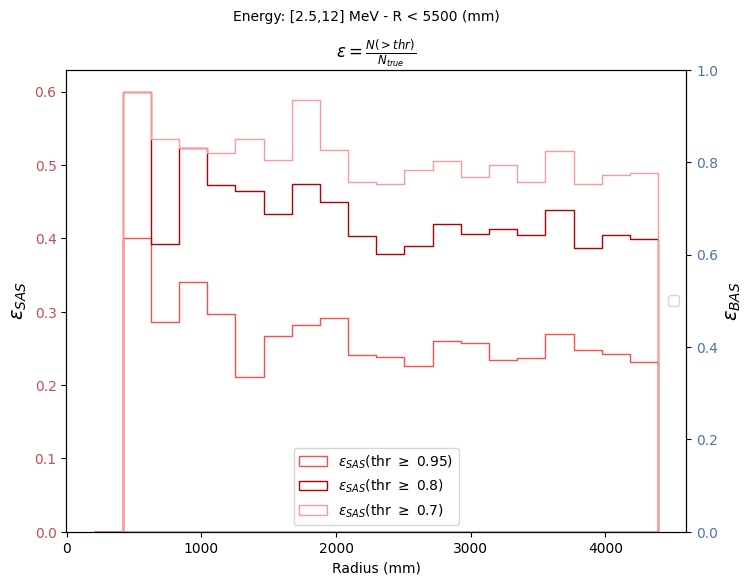

In [71]:
bas_on = False

#main plot: Test Solar radius vs. Normalized efficiency
fig, axes_1 = plt.subplots(figsize =(8, 6))
axes_2 = axes_1.twinx()

for i_dx, thr_i in enumerate(thr):  
    #Sig Efficiency normalized by N_true counts
    sn.histplot(x = mean_rad_sig[i_dx], ax = axes_1,bins = len(mean_rad_sig[i_dx]), color = red_variants[i_dx], 
                weights = norm_eff_sig_in_sas[i_dx], element = 'step', alpha = 0.0, label = r'$\epsilon_{SAS}$(thr $\geq$ '+str(thr_i)+')')

    if bas_on:
        #bkg efficiency
        sn.histplot(x = mean_rad_bkg[i_dx], ax = axes_2, bins=len(mean_rad_bkg[i_dx]), color = blue_variants[i_dx], kde=False,
                    weights = norm_eff_bkg_in_bas[i_dx], element = 'step', alpha = 0.0, label = r'$\epsilon_{BAS}$(thr $\geq$ '+str(thr_i)+')')
        

plt.suptitle('Energy: [2.5,12] MeV - R < 5500 (mm)', fontsize = 10)
axes_1.set_title(r'$\epsilon = \frac{N(>thr)}{N_{true}}$', fontsize = 12)
axes_1.legend(loc = 'lower center')
axes_2.legend(loc = 'center right')

axes_1.tick_params(axis='y', labelcolor='r')
axes_2.tick_params(axis='y', labelcolor='b')


axes_1.set_xlabel('Radius (mm)')
axes_1.set_ylabel(r'$\epsilon_{SAS}$', fontsize = 14)
axes_2.set_ylabel(r'$\epsilon_{BAS}$', fontsize = 14)

#axes_1.set_xlim(0, 5500.0)
#axes_2.set_ylim(0, np.max(norm_eff_bkg_in_bas) + 0.15)
#axes_1.set_yscale('log')

#if bas_on:
#    plt.savefig('figs/Optimized Models/10x10/Radial_sig_bkg_thr_and_Norm_eff.png', format = 'png', bbox_inches = 'tight')
#else:
#    plt.savefig('figs/Optimized Models/10x10/Radial_thr_and_Norm_eff.png', format = 'png', bbox_inches = 'tight')
plt.show()